In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import IsolationForest
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

pd.pandas.set_option('display.max_columns', None)
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
project_path = r'C:\Users\kchanas\Documents\Learning\Kaggle\Titanic'

In [3]:
train = pd.read_csv(os.path.join(project_path, r'data\train.csv')).set_index('PassengerId')
test = pd.read_csv(os.path.join(project_path, r'data\test.csv')).set_index('PassengerId')

In [4]:
print(train.head())
print(train.info())

             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S

In [5]:
print(test.head())
print(test.info())

             Pclass                                          Name     Sex  \
PassengerId                                                                 
892               3                              Kelly, Mr. James    male   
893               3              Wilkes, Mrs. James (Ellen Needs)  female   
894               2                     Myles, Mr. Thomas Francis    male   
895               3                              Wirz, Mr. Albert    male   
896               3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

              Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
PassengerId                                                       
892          34.5      0      0   330911   7.8292   NaN        Q  
893          47.0      1      0   363272   7.0000   NaN        S  
894          62.0      0      0   240276   9.6875   NaN        Q  
895          27.0      0      0   315154   8.6625   NaN        S  
896          22.0      1      1  3101298  12.2875   NaN   

The Titanic train dataset contains 891 rows, i.e., passengers, and 11 columns, i.e., variables.
The Titanic test dataset contains 418 rows, i.e., passengers, and 10 columns, i.e., variables.

## Extract features from Name, Ticket and Cabin

In [6]:
def extract_title(name): 
    parts_of_name = name.split()
    parts_of_name = [part for part in parts_of_name if '.' in part]
    return parts_of_name[0]

train['Title'] = train['Name'].apply(extract_title)
test['Title'] = test['Name'].apply(extract_title)

In [7]:
def extract_ticket_type(df):
    df = df.copy()
    df['Ticket_number'] = pd.to_numeric(df['Ticket'], errors='coerce')
    df['Ticket_number_str'] = df['Ticket_number'].astype(str)
    df['Ticket_length'] = df['Ticket_number_str'].apply(lambda x: len(x.replace('.0', '')))

    ticket_type = []
    ticket = df['Ticket']
    ticket_number = df['Ticket_number']
    ticket_length = df['Ticket_length']

    for t, t_number, t_length in zip(ticket, ticket_number, ticket_length):
        if t_length > 3:
            t_type = str(t_length) + '-digit'
        else:
            for text in ['A','C','F','L','P','S','SOTON','STON','W']:
                if t.startswith(text):
                    t_type = text
                    break
                else:
                    t_type = 'Other'
        ticket_type.append(t_type)
    return ticket_type

train['Ticket_Type'] = extract_ticket_type(train)
test['Ticket_Type'] = extract_ticket_type(test)

In [8]:
train['Cabin_Type'] = np.where(train['Cabin'].notnull(), train['Cabin'].str[0], 'NoCabin')
test['Cabin_Type'] = np.where(test['Cabin'].notnull(), test['Cabin'].str[0], 'NoCabin')

In [9]:
train = train.drop(['Name','Ticket','Cabin'],axis=1)
test = test.drop(['Name','Ticket','Cabin'],axis=1)

## Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train, train['Survived'], test_size=0.3, random_state=1, stratify=train['Survived'])  

In [11]:
X_train.head()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 473 to 465
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     623 non-null    int64  
 1   Pclass       623 non-null    int64  
 2   Sex          623 non-null    object 
 3   Age          501 non-null    float64
 4   SibSp        623 non-null    int64  
 5   Parch        623 non-null    int64  
 6   Fare         623 non-null    float64
 7   Embarked     621 non-null    object 
 8   Title        623 non-null    object 
 9   Ticket_Type  623 non-null    object 
 10  Cabin_Type   623 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 58.4+ KB


In [12]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True)) 

0    0.616372
1    0.383628
Name: Survived, dtype: float64
0    0.615672
1    0.384328
Name: Survived, dtype: float64


**We will analyse these datasets to identify:**

1. Missing values
2. Numerical variables
3. Distribution of the numerical variables
4. Discrete variables
6. Categorical variables
7. Cardinality of the categorical variables
8. Potential relationships between the variables and the target: Survived 

In [13]:
vars_with_na = [col for col in test.columns if (train[col].isnull().sum() > 0) or (test[col].isnull().sum() > 0)]
print(X_train[vars_with_na].isnull().mean().sort_values(ascending=False))
print(X_test[vars_with_na].isnull().mean().sort_values(ascending=False))
print(test[vars_with_na].isnull().mean().sort_values(ascending=False))

Age         0.195827
Embarked    0.003210
Fare        0.000000
dtype: float64
Age         0.205224
Embarked    0.000000
Fare        0.000000
dtype: float64
Age         0.205742
Fare        0.002392
Embarked    0.000000
dtype: float64


In [14]:
def concatenate_datasets(X_train, X_test, test=None):
    X_train = X_train.copy()
    X_test = X_test.copy()
    X_train['Dataset'] = 'X_train'
    X_test['Dataset'] = 'X_test'
    if isinstance(test, pd.DataFrame):
        test = test.copy()
        test['Dataset'] = 'test'
        df = pd.concat([X_train, X_test, test])
    else:
        df = pd.concat([X_train, X_test])
    return df

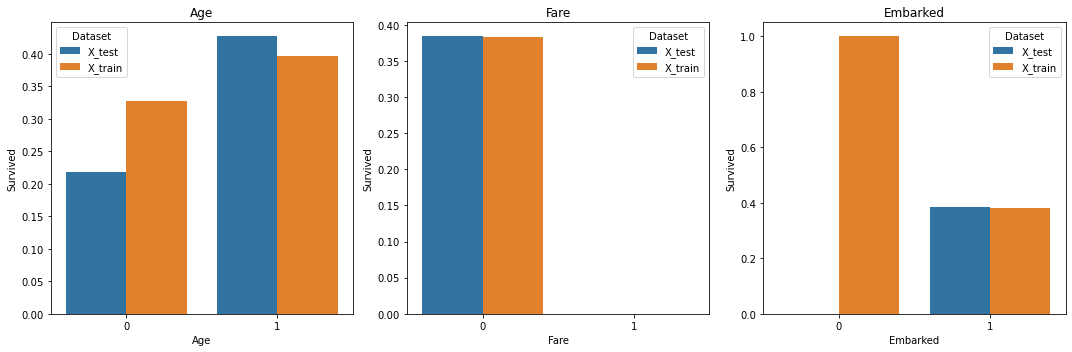

In [15]:
def analyze_na_values(X_train, X_test, var):
    df = concatenate_datasets(X_train, X_test)
    df[var] = np.where(df[var].isnull(), 0, 1)
    df = df.groupby(['Dataset', var])['Survived'].mean().reset_index()
    return df

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(15,5))

for var, ax in zip(train[vars_with_na].columns, [ax1, ax2, ax3]):
    df = analyze_na_values(X_train, X_test, var)
    sns.barplot(y='Survived', x=var, hue='Dataset', data=df, ax=ax)
    ax.set_title(label=var)
plt.tight_layout()
plt.show()

In all cases the percentage of passengers who survived differs between observations with missing information and the ones where information exists

## Types of variables

In [16]:
num_vars = [var for var in train.columns if train[var].dtypes != 'O' and var not in 'Survived']
discrete_vars = [var for var in num_vars if train[var].nunique() <= 20 and var not in 'Survived']
num_vars = [var for var in num_vars if var not in discrete_vars]
cat_vars = [var for var in train.columns if train[var].dtypes == 'O']

print('Numeric variables: ', num_vars)
print('Discrete variables: ', discrete_vars)
print('Categorical variables: ', cat_vars)

Numeric variables:  ['Age', 'Fare']
Discrete variables:  ['Pclass', 'SibSp', 'Parch']
Categorical variables:  ['Sex', 'Embarked', 'Title', 'Ticket_Type', 'Cabin_Type']


## Numerical variables

#### Variables distribution

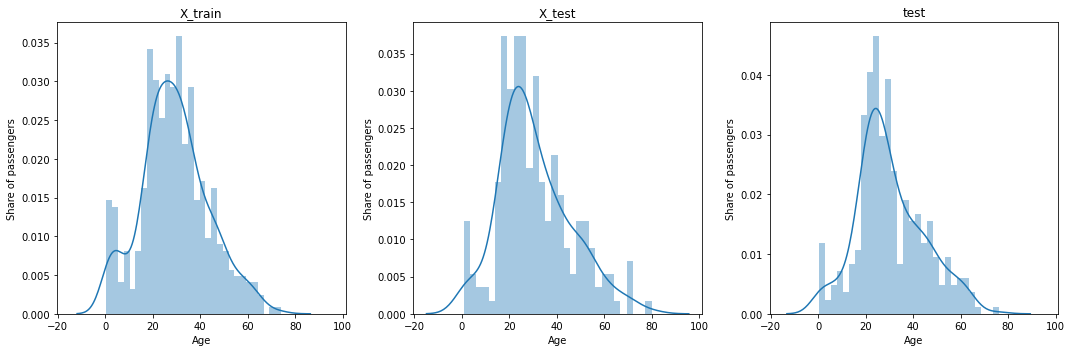

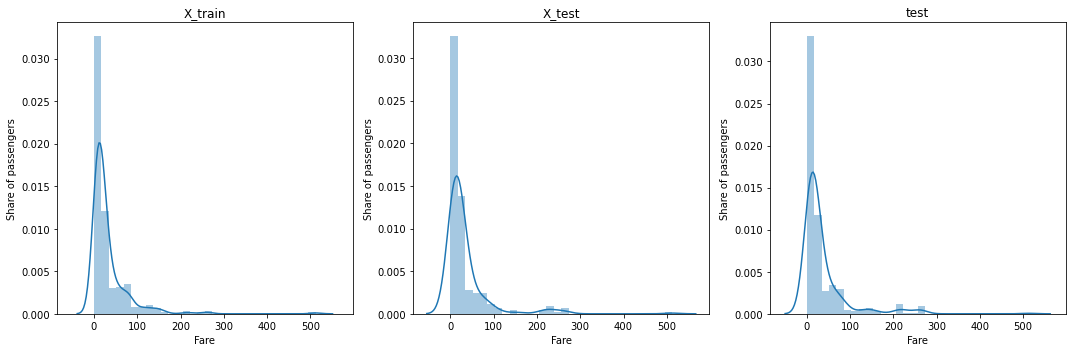

In [17]:
df = concatenate_datasets(X_train, X_test, test)

for var in num_vars:
    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
    for dataset, ax in zip(df['Dataset'].unique(), axes.flatten()):
        sns.distplot(x=df[df['Dataset']==dataset][var], ax=ax, bins=30)
        ax.set_xlabel(var)
        ax.set_ylabel('Share of passengers')
        ax.set_title(dataset)
    plt.tight_layout()
    plt.show()

The distribution of both numerical variables in both datasets is not normal, so in the next step I check how PowerTransformer works with these variables.

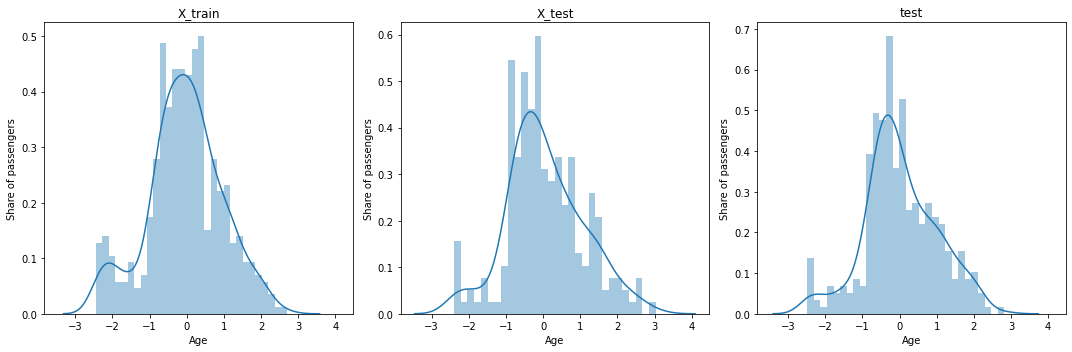

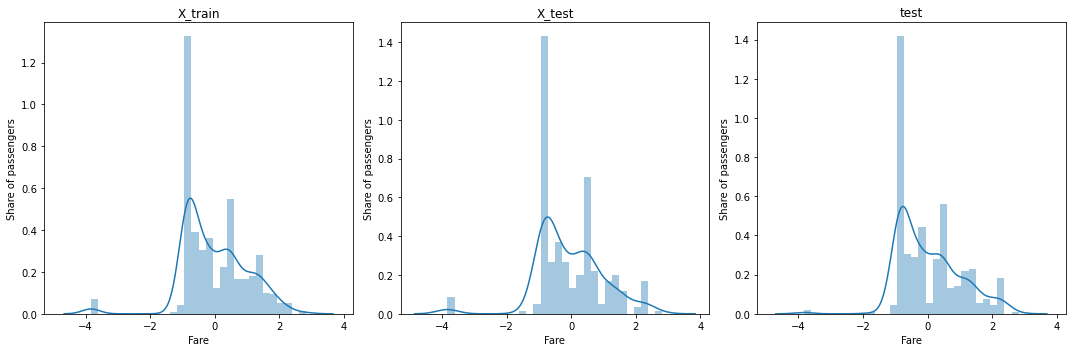

In [18]:
df = concatenate_datasets(X_train, X_test, test)

for var in num_vars:
    pt = PowerTransformer()
    df = df.copy()
    df[var] = pt.fit_transform(np.array(df[var]).reshape(-1,1))
    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
    for dataset, ax in zip(df['Dataset'].unique(), axes.flatten()):
        sns.distplot(x=df[df['Dataset']==dataset][var], ax=ax, bins=30)
        ax.set_xlabel(var)
        ax.set_ylabel('Share of passengers')
        ax.set_title(dataset)
    plt.tight_layout()
    plt.show()

#### Relation with target

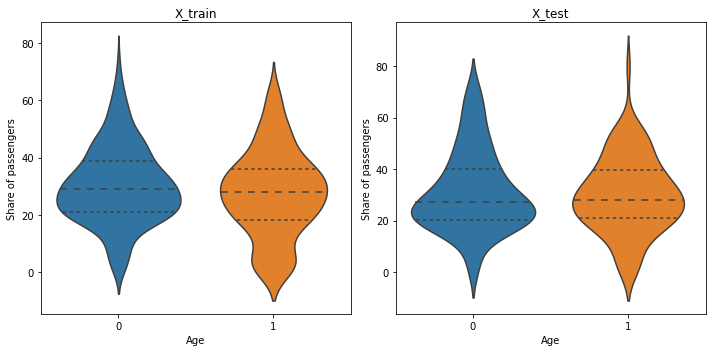

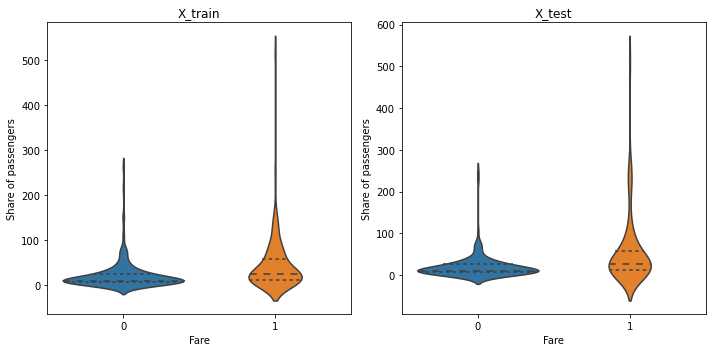

In [19]:
df = concatenate_datasets(X_train, X_test)

for var in num_vars:
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
    for dataset, ax in zip(df['Dataset'].unique(), axes.flatten()):
        tmp = df[df['Dataset']==dataset]
        sns.violinplot(x='Survived', y=var, data=tmp, inner='quartile', ax=ax)
        ax.set_xlabel(var)
        ax.set_ylabel('Share of passengers')
        ax.set_title(dataset)
    plt.tight_layout()
    plt.show()

It seems that these two variables only slightly distiguish passengers who survived and not. Maybe in connection with discrete or categorical variables they can show more useful information. Let's try to bucketize them.

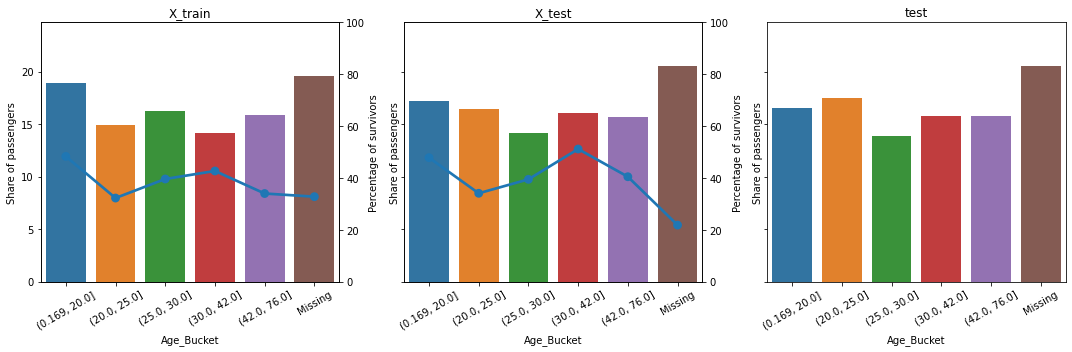

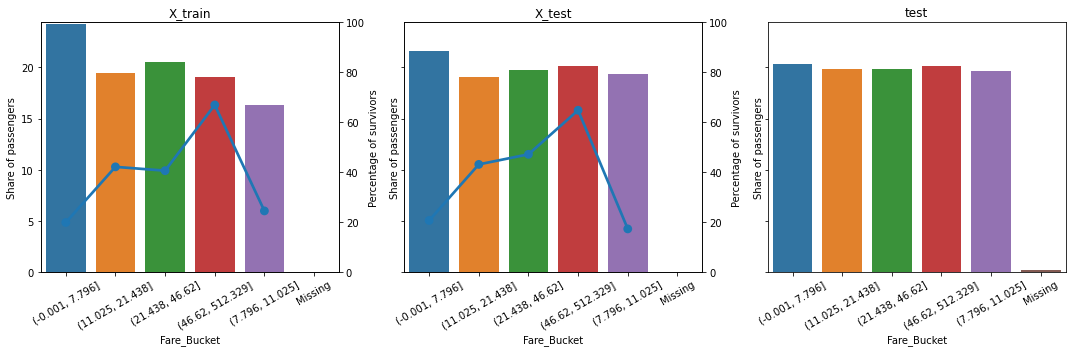

In [103]:
for df in [X_train, X_test, test]:
    df['Age_Bucket'] = pd.qcut(df['Age'], q=5).astype(str)
    df['Fare_Bucket'] = pd.qcut(df['Fare'], q=5).astype(str)
    df['Age_Bucket'] = np.where(df['Age_Bucket']=='nan', 'Missing', df['Age_Bucket'])
    df['Fare_Bucket'] = np.where(df['Fare_Bucket']=='nan', 'Missing', df['Fare_Bucket'])
    
df = concatenate_datasets(X_train, X_test, test)
for var in ['Age_Bucket','Fare_Bucket']:
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
    for dataset, ax in zip(df['Dataset'].unique(), axes.flatten()):
        tmp = df[df['Dataset']==dataset]
        tmp_a = tmp.groupby(var)['Embarked'].count() / tmp.shape[0] * 100
        tmp_a = tmp_a.rename('Percent').reset_index()
        sns.barplot(x=var, y='Percent', data=tmp_a, ax=ax)
        if dataset in ['X_train','X_test']:
            ax1 = ax.twinx()
            tmp_s = tmp.groupby(var)['Survived'].mean().mul(100).reset_index()
            sns.pointplot(x=var, y='Survived', data=tmp_s, ax=ax1)
            ax1.set_ylabel('Percentage of survivors')
            ax1.set_ylim(0,100)
        ax_max = tmp_a['Percent'].max() * 1.2
        ax.set_title(dataset)
        ax.set_xlabel(var)
        ax.set_ylabel('Share of passengers')
        ax.set_ylim(0,ax_max)
        labels = ax.get_xticklabels() 
       # for i,l in enumerate(labels):
        #    if(i%2 == 0): labels[i] = ''
        ax.set_xticklabels(labels, rotation=30)
    plt.tight_layout()
    plt.show()

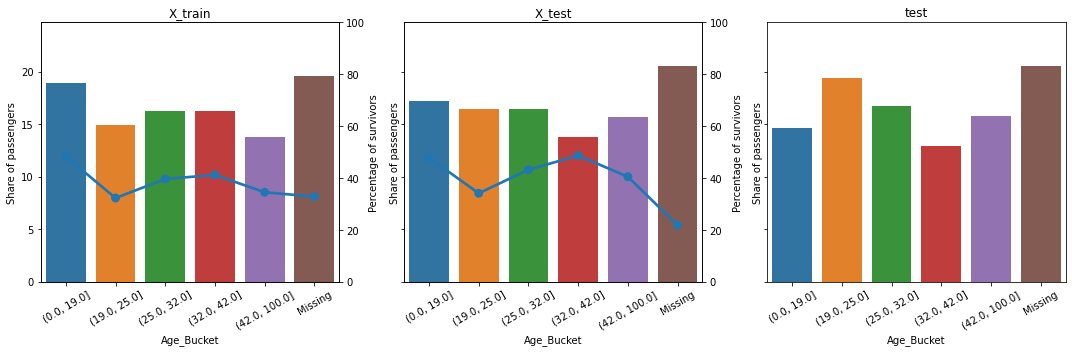

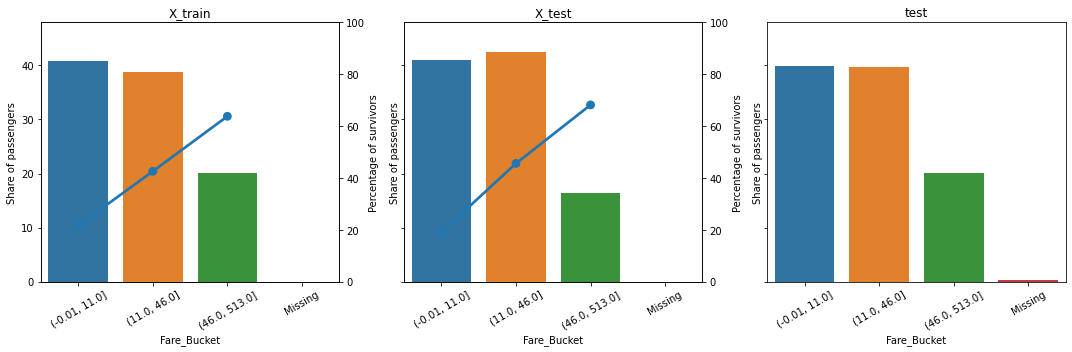

In [106]:
for df in [X_train, X_test, test]:
    df['Age_Bucket'] = pd.cut(df['Age'], bins=[0,19,25,32,42,100]).astype(str)
    df['Fare_Bucket'] = pd.cut(df['Fare'], bins=[-0.01,11,46,513]).astype(str)
    df['Age_Bucket'] = np.where(df['Age_Bucket']=='nan', 'Missing', df['Age_Bucket'])
    df['Fare_Bucket'] = np.where(df['Fare_Bucket']=='nan', 'Missing', df['Fare_Bucket'])
    
df = concatenate_datasets(X_train, X_test, test)
for var in ['Age_Bucket','Fare_Bucket']:
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
    for dataset, ax in zip(df['Dataset'].unique(), axes.flatten()):
        tmp = df[df['Dataset']==dataset]
        tmp_a = tmp.groupby(var)['Embarked'].count() / tmp.shape[0] * 100
        tmp_a = tmp_a.rename('Percent').reset_index()
        sns.barplot(x=var, y='Percent', data=tmp_a, ax=ax)
        if dataset in ['X_train','X_test']:
            ax1 = ax.twinx()
            tmp_s = tmp.groupby(var)['Survived'].mean().mul(100).reset_index()
            sns.pointplot(x=var, y='Survived', data=tmp_s, ax=ax1)
            ax1.set_ylabel('Percentage of survivors')
            ax1.set_ylim(0,100)
        ax_max = tmp_a['Percent'].max() * 1.2
        ax.set_title(dataset)
        ax.set_xlabel(var)
        ax.set_ylabel('Share of passengers')
        ax.set_ylim(0,ax_max)
        labels = ax.get_xticklabels() 
       # for i,l in enumerate(labels):
        #    if(i%2 == 0): labels[i] = ''
        ax.set_xticklabels(labels, rotation=30)
    plt.tight_layout()
    plt.show()

## Discrete variables

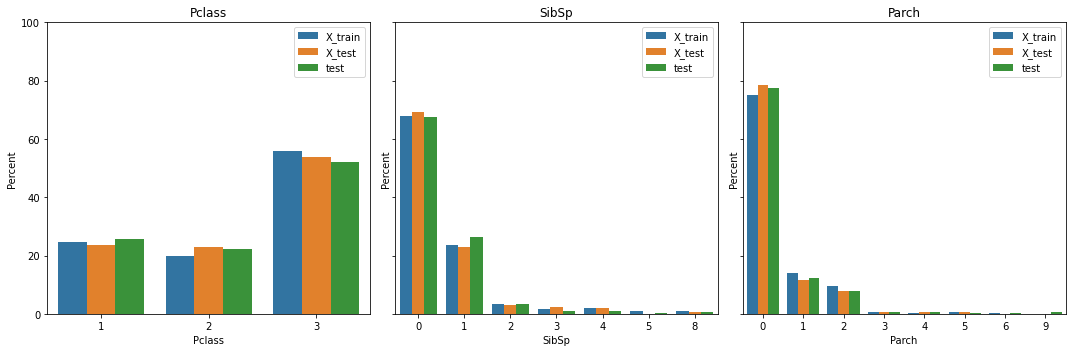

In [80]:
def not_num_vars_distribution(X_train, X_test, test, var):
    df = concatenate_datasets(X_train, X_test, test)
    df = df.groupby('Dataset')[var].value_counts(normalize=True) * 100
    df = df.rename('Percent').reset_index()
    return df

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))

for var, ax in zip(discrete_vars, [ax1, ax2, ax3]):
    df = not_num_vars_distribution(X_train, X_test, test, var)
    sns.barplot(data=df, x=var, y='Percent', hue='Dataset', ax=ax, hue_order=['X_train','X_test','test'])
    ax.set_ylim(0,100)
    ax.set_title(label=var)
    ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

#### Relation with target

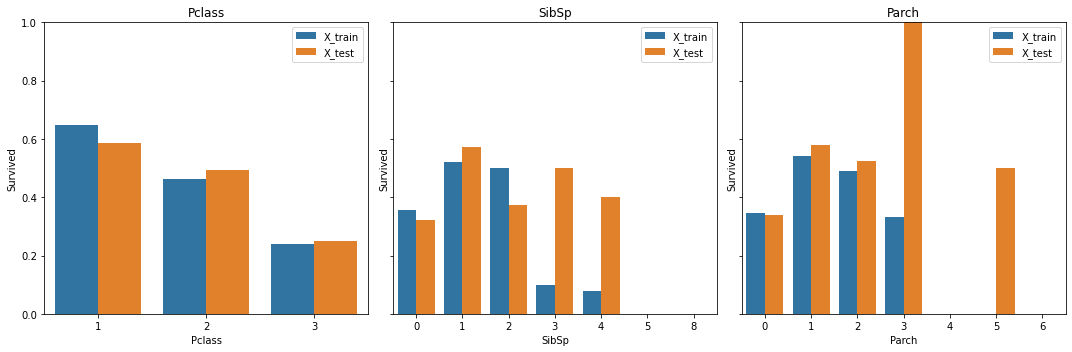

In [81]:
def analyze_not_num_relation_with_target(X_train, X_test, var):
    df = concatenate_datasets(X_train, X_test) 
    df = df.groupby(['Dataset', var])['Survived'].mean().reset_index()
    return df

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))

for var, ax in zip(discrete_vars, [ax1, ax2, ax3]):
    df = analyze_not_num_relation_with_target(X_train, X_test, var)
    sns.barplot(data=df, x=var, y='Survived', hue='Dataset', ax=ax, hue_order=['X_train','X_test'])
    ax.set_ylim(0,1)
    ax.set_title(label=var)
    ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

The best candidate for a good predictor is Pclass (ticket class), because the higher class passenger travelled in, the more possible it was for him to survive the catastrophy. 

SibSp (number of siblings/spouses aboard Titanic) and Parch (number of parents/children aboard Titanic) can be also a good candidates. It is crucial to make not overfitted models because for SibSp and Parch percentage of survivors are different in train and test set.

Let's try to make categories out of SibSp and Parch and analyze their distribution and relation with target.

In [82]:
for df in [X_train, X_test, test]:
    df['SibSp_'] = np.where(df['SibSp']>=2, '2>=', df['SibSp'])
    df['Parch_'] = np.where(df['Parch']>=2, '2>=', df['Parch'])
    df['SibSp'] = df['SibSp_'].copy()
    df['Parch'] = df['Parch_'].copy()

X_train = X_train.drop(['SibSp_','Parch_'], axis=1)
X_test = X_test.drop(['SibSp_','Parch_'], axis=1)
test = test.drop(['SibSp_','Parch_'], axis=1)
X_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Ticket_Type,Cabin_Type,Age_Bucket,Fare_Bucket
PassengerId,,,,,,,,,,,,,
473,1,2,female,33.0,1,2>=,27.7500,S,Mrs.,C,NoCabin,"(32, 42]","(11.0, 46.0]"
598,0,3,male,49.0,0,0,0.0000,S,Mr.,L,NoCabin,"(42, 100]","(-0.01, 11.0]"
844,0,3,male,34.5,0,0,6.4375,C,Mr.,4-digit,NoCabin,"(32, 42]","(-0.01, 11.0]"
113,0,3,male,22.0,0,0,8.0500,S,Mr.,6-digit,NoCabin,"(19, 25]","(-0.01, 11.0]"
870,1,3,male,4.0,1,1,11.1333,S,Master.,6-digit,NoCabin,"(0, 19]","(11.0, 46.0]"


## Categorical variables

#### Variables cardinality and distribution

In [83]:
cat_vars = cat_vars + ['SibSp','Parch','Age_Bucket','Fare_Bucket']

for var in cat_vars:
    print(var + ': ', X_train[var].nunique())

Sex:  2
Embarked:  3
Title:  13
Ticket_Type:  12
Cabin_Type:  9
SibSp:  3
Parch:  3
Age_Bucket:  5
Fare_Bucket:  3


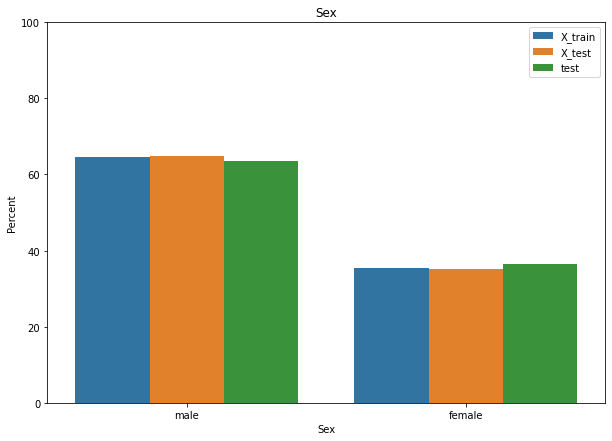

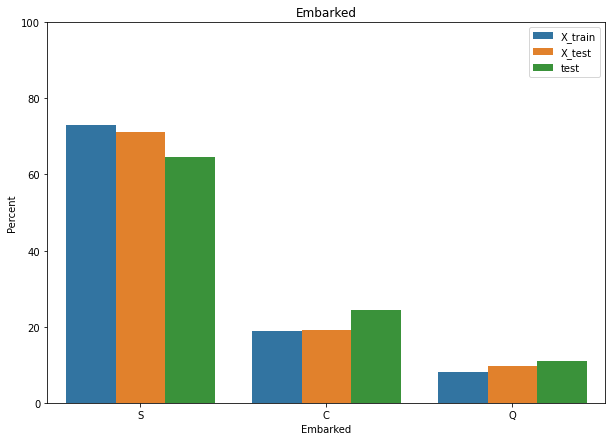

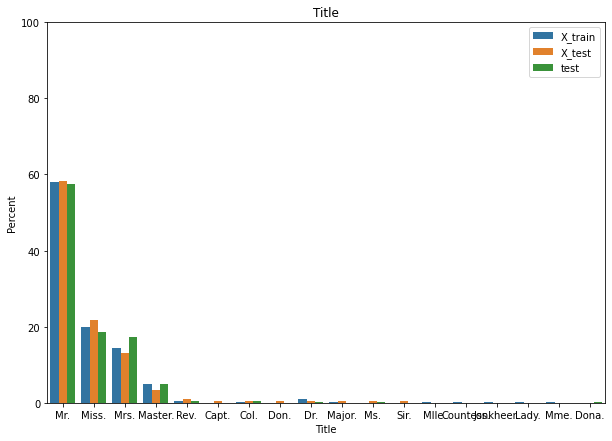

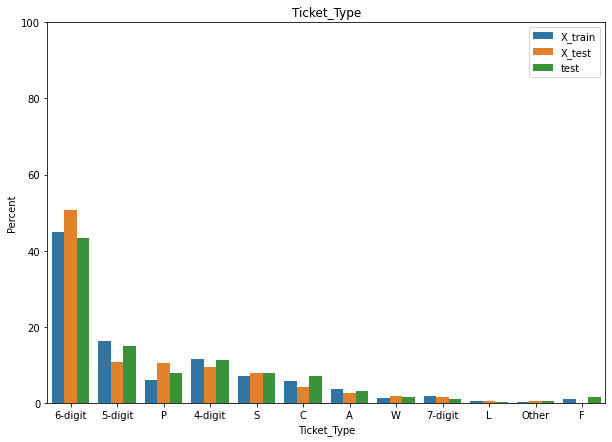

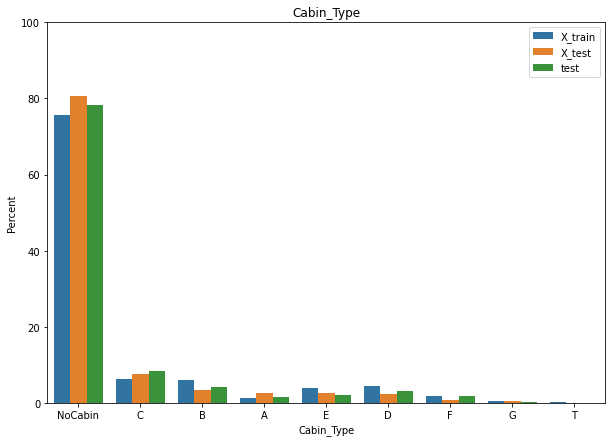

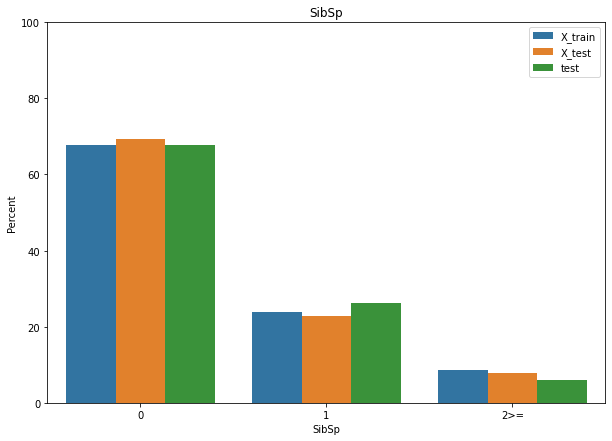

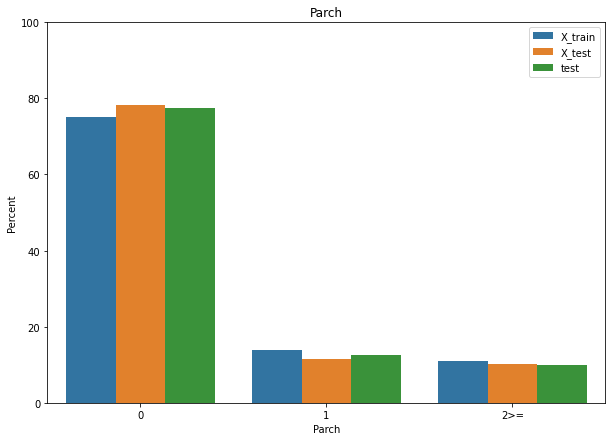

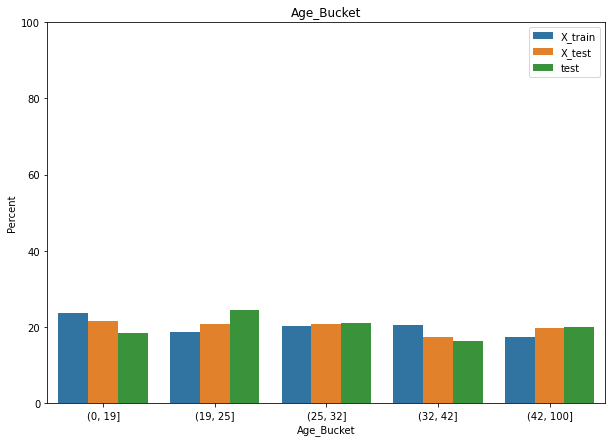

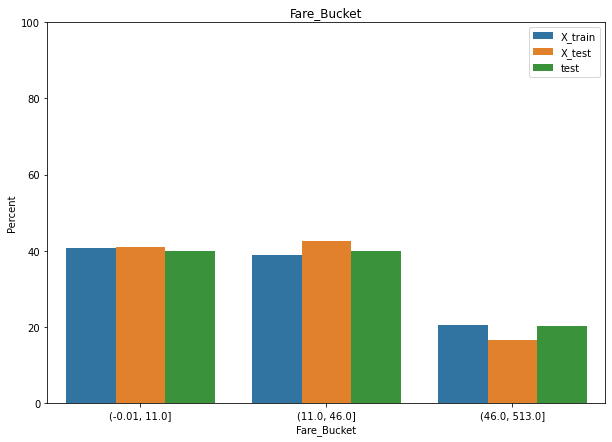

In [84]:
for var in cat_vars:
    df = not_num_vars_distribution(X_train, X_test, test, var)
    sns.barplot(data=df, x=var, y='Percent', hue='Dataset', hue_order=['X_train','X_test','test'])
    plt.title(label=var)
    plt.ylim(0,100)
    plt.legend(loc='upper right')
    plt.show()

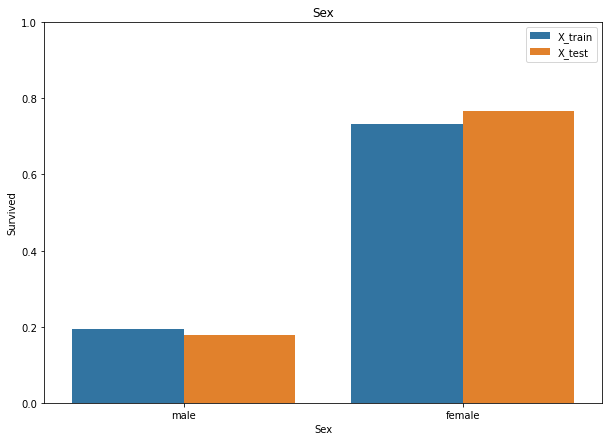

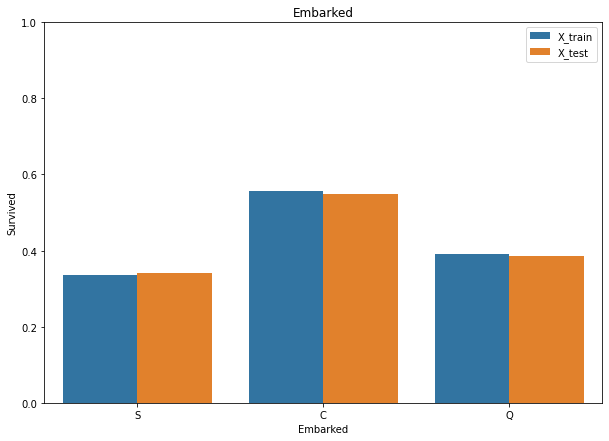

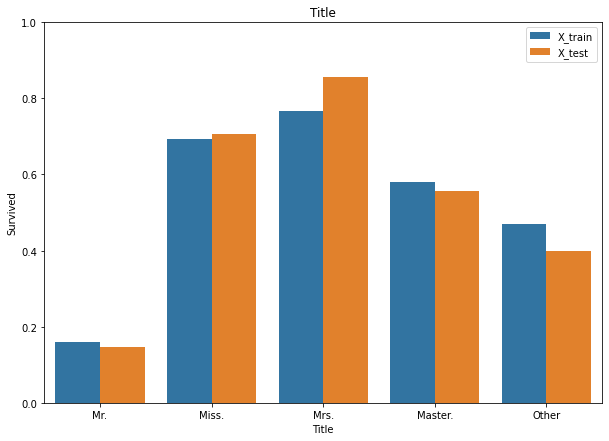

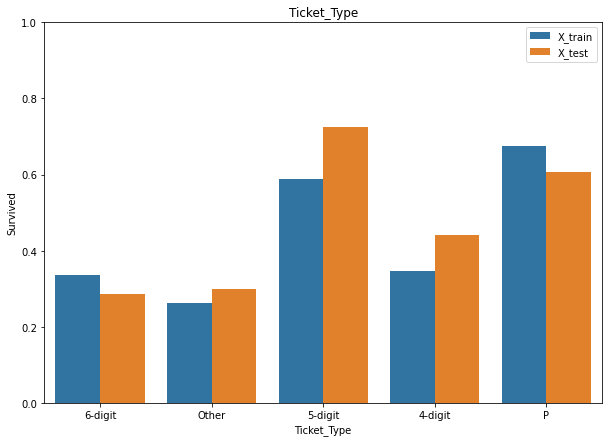

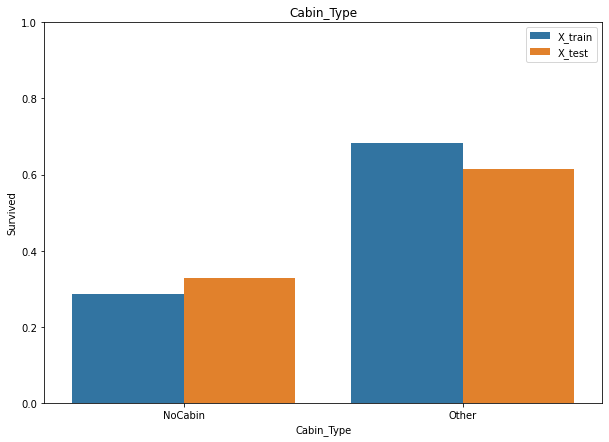

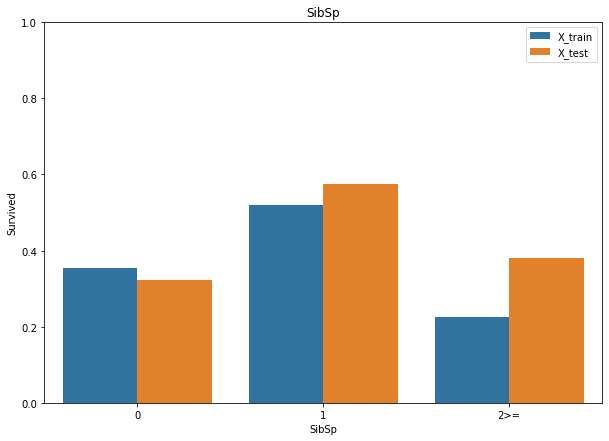

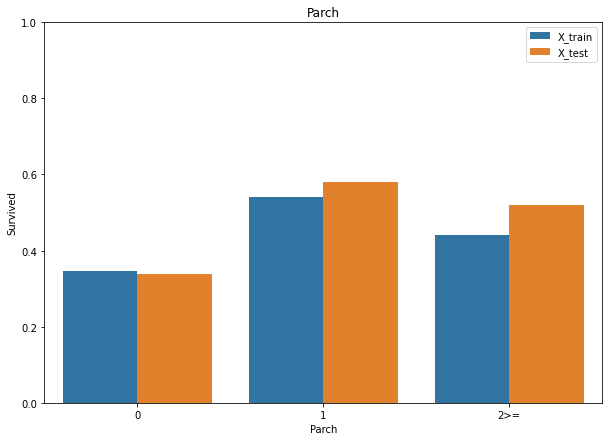

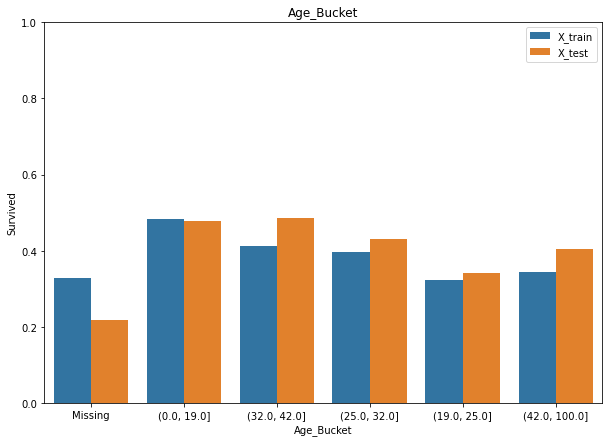

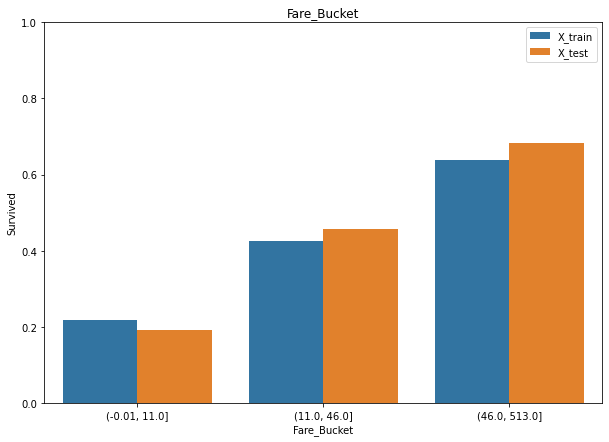

In [107]:
def categories_order(df, var):
    df = df[var].value_counts(normalize=True) * 100
    return df.index

for var in cat_vars:
    df = analyze_not_num_relation_with_target(X_train, X_test, var)
    order = categories_order(X_train, var)
    sns.barplot(data=df, x=var, y='Survived', hue='Dataset', hue_order=['X_train','X_test'], order=order)
    plt.ylim(0,1)
    plt.title(label=var)
    plt.legend(loc='upper right')
    plt.show()

All of categorical variables can be a good candidates for predictors of surviving, as the percentage of survivors between categories strongly differs. Let's try to lower cardinality of variables and see how it affects distribution and relations with target.

In [108]:
categories_labels = {'Title': ['Mr.','Mrs.','Miss.','Master.'],
                    'Ticket_Type': ['4-digit','5-digit','6-digit','P'],
                    'Cabin_Type': ['NoCabin']}

for var in ['Title','Ticket_Type','Cabin_Type']:
    for df in [X_train, X_test, test]:
        df[var] = np.where(df[var].isin(categories_labels[var]), df[var], 'Other')

In [109]:
def categories_order(df, var):
    df = df[var].value_counts(normalize=True) * 100
    return df    
    
def categories_frequency(X_train, X_test, var, order):
    dataset_dict = {'X_train': 0, 'X_test': 1}
    order = categories_order(X_train, var)
    order_dict = {k: i for i, k in enumerate(order.index)}
    df = concatenate_datasets(X_train, X_test)
    df = df.groupby('Dataset')[var].value_counts(normalize=True) * 100
    df = df.rename('Percent').reset_index()
    df['Dataset'] = df['Dataset'].map(dataset_dict)
    df[var] = df[var].map(order_dict)
    df = df.sort_values(by=['Dataset',var])
    return df['Percent']

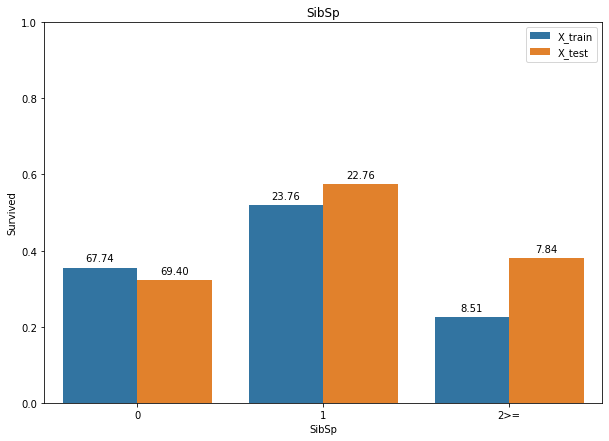

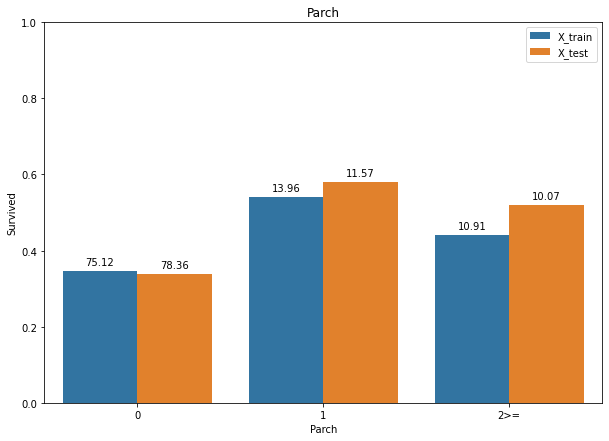

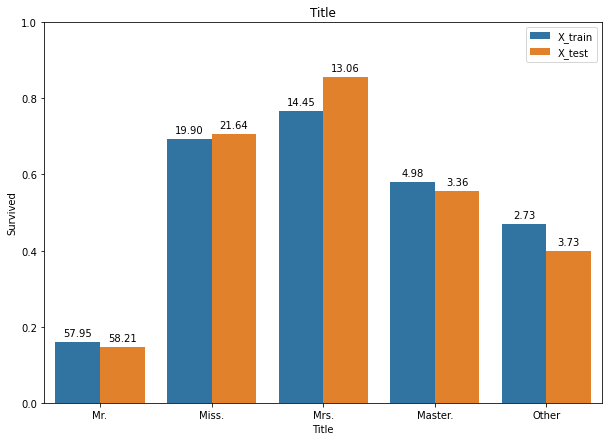

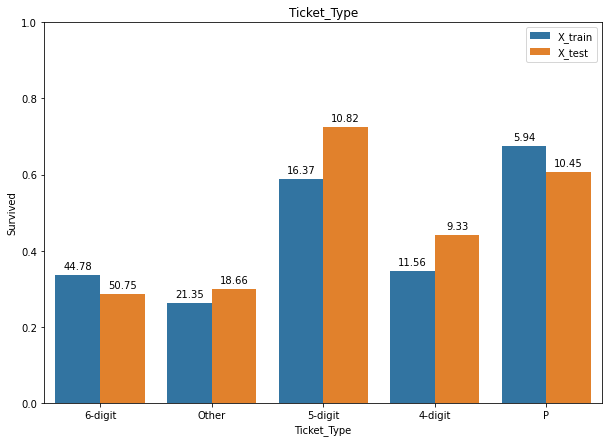

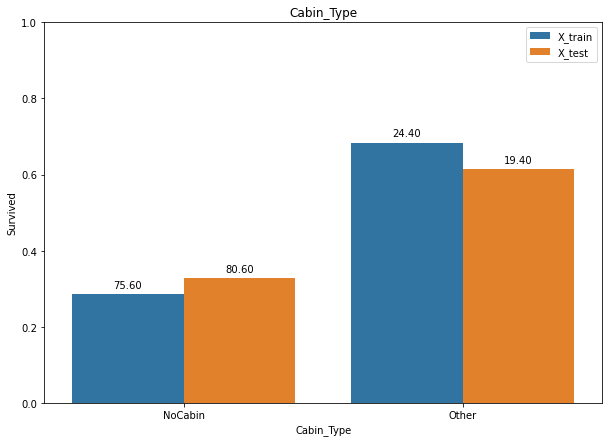

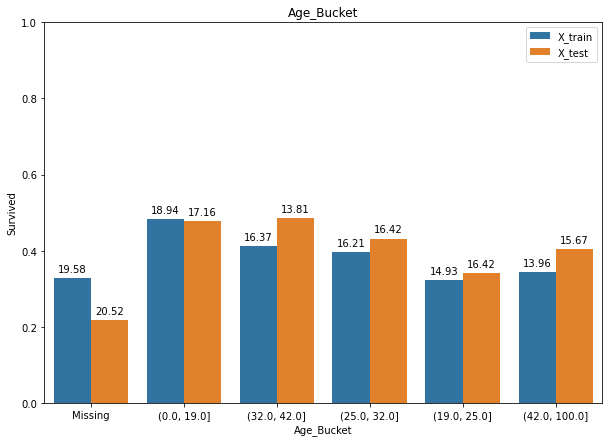

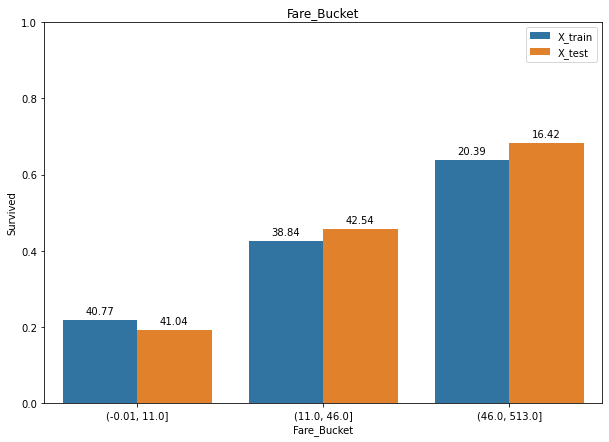

In [110]:
for var in ['SibSp','Parch','Title','Ticket_Type','Cabin_Type','Age_Bucket','Fare_Bucket']:
    df = analyze_not_num_relation_with_target(X_train, X_test, var)
    order = categories_order(X_train, var)
    splot = sns.barplot(data=df, x=var, y='Survived', hue='Dataset', hue_order=['X_train','X_test'], order=order.index)
    cat_freq = categories_frequency(X_train, X_test, var, order)
    for p, freq in zip(splot.patches, cat_freq):
        splot.annotate(format(freq, '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    plt.ylim(0,1)
    plt.title(label=var)
    plt.legend(loc='upper right')
    plt.show()

## Relations between predictors and target

In [111]:
X_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Ticket_Type,Cabin_Type,Age_Bucket,Fare_Bucket
PassengerId,,,,,,,,,,,,,
473,1,2,female,33.0,1,2>=,27.7500,S,Mrs.,Other,NoCabin,"(32.0, 42.0]","(11.0, 46.0]"
598,0,3,male,49.0,0,0,0.0000,S,Mr.,Other,NoCabin,"(42.0, 100.0]","(-0.01, 11.0]"
844,0,3,male,34.5,0,0,6.4375,C,Mr.,4-digit,NoCabin,"(32.0, 42.0]","(-0.01, 11.0]"
113,0,3,male,22.0,0,0,8.0500,S,Mr.,6-digit,NoCabin,"(19.0, 25.0]","(-0.01, 11.0]"
870,1,3,male,4.0,1,1,11.1333,S,Master.,6-digit,NoCabin,"(0.0, 19.0]","(11.0, 46.0]"


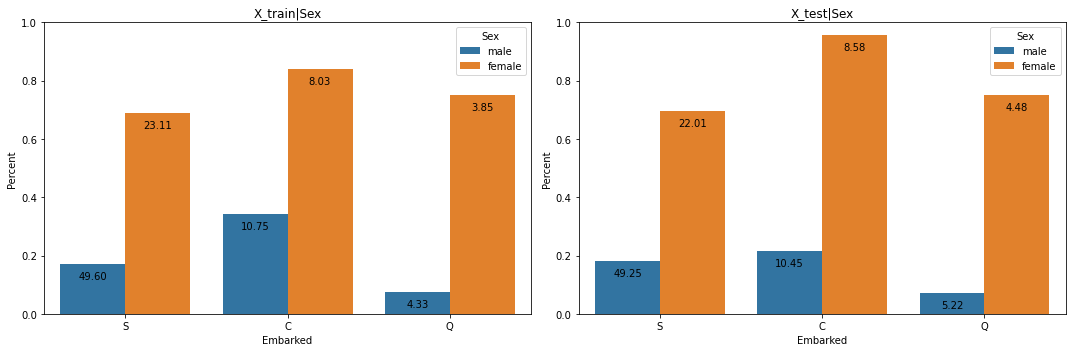

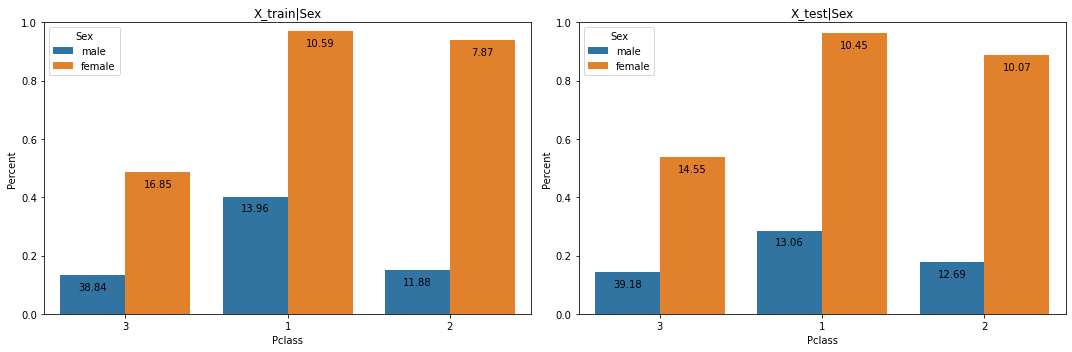

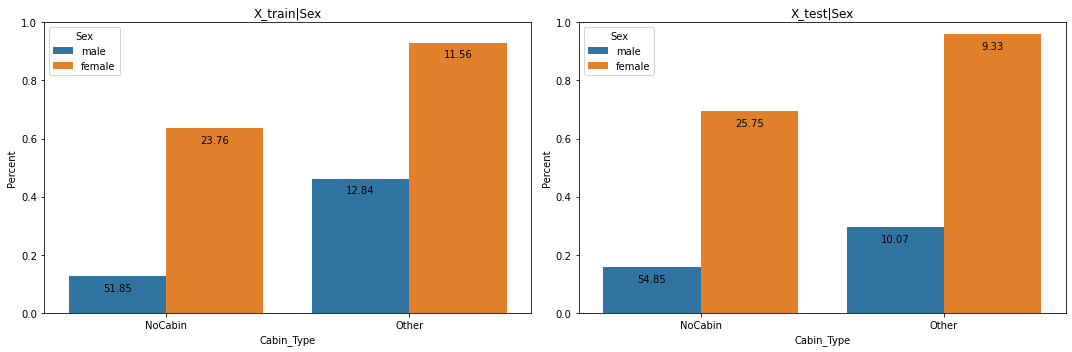

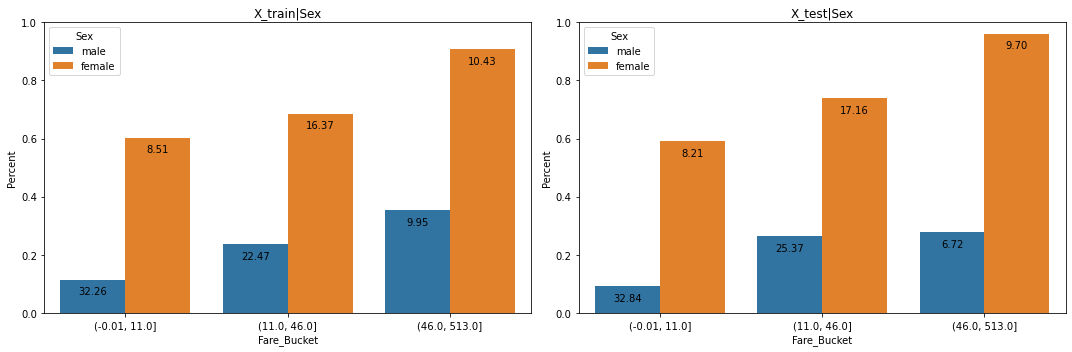

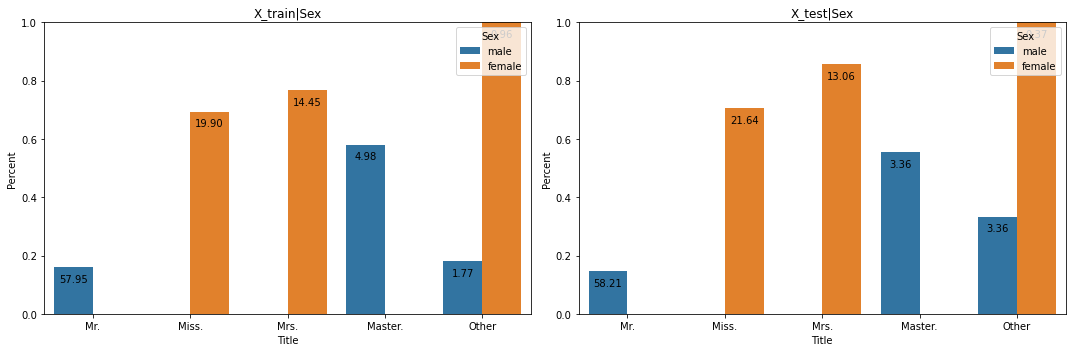

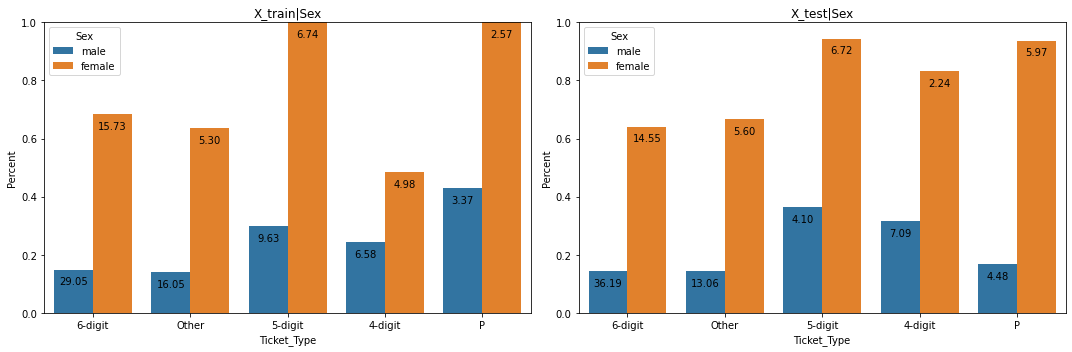

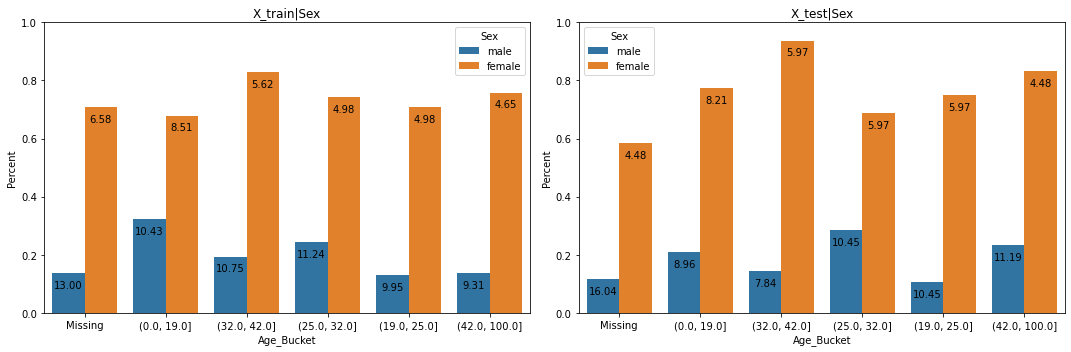

In [112]:
def ensure_all_combinations(df, var_1, var_2):
    df = df.copy()
    df_var1 = df[[var_1]].drop_duplicates()
    df_var2 = df[[var_2]].drop_duplicates()
    df_var1['Fake'] = 1
    df_var2['Fake'] = 1
    return pd.merge(df_var1, df_var2, on='Fake').drop('Fake', axis=1)

def two_categories_frequency(df, var_1, var_2):
    order_var1 = categories_order(X_train, var_1)
    order_var2 = categories_order(X_train, var_2)
    order_var1 = {k: str(i) for i, k in enumerate(order_var1.index)}
    order_var2 = {k: str(i) for i, k in enumerate(order_var2.index)}
    df = df.groupby([var_1,var_2])['Survived'].count() / df.shape[0] * 100
    df = df.rename('Percent').reset_index()
    df[var_1] = df[var_1].map(order_var1)
    df[var_2] = df[var_2].map(order_var2)
    tmp = ensure_all_combinations(df, var_1, var_2)
    df = pd.merge(tmp, df, on = [var_1, var_2], how='left').fillna(0)
    df = df.sort_values(by=[var_1,var_2])
    return df['Percent']

def two_categories_relation_with_target(X_train, X_test, var_1, var_2):
    df_train = X_train.groupby([var_1, var_2])['Survived'].mean().rename('Percent').reset_index()
    df_test = X_test.groupby([var_1, var_2])['Survived'].mean().rename('Percent').reset_index()
    order_var2 = categories_order(X_train, var_2)
    order_var1 = categories_order(X_train, var_1)
    cat_freq_train = two_categories_frequency(X_train, var_1, var_2)
    cat_freq_test = two_categories_frequency(X_test, var_1, var_2)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15,5))
    splot1 = sns.barplot(data=df_train, x=var_2, y='Percent', hue=var_1 , ax=ax1, order=order_var2.index, hue_order=order_var1.index)
    for p, freq in zip(splot1.patches, cat_freq_train):
        ax1.annotate(format(freq, '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), 
                   textcoords = 'offset points')
    splot2 = sns.barplot(data=df_test, x=var_2, y='Percent', hue=var_1 , ax=ax2, order=order_var2.index, hue_order=order_var1.index)
    for p, freq in zip(splot2.patches, cat_freq_test):
        ax2.annotate(format(freq, '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), 
                   textcoords = 'offset points')
    ax1.set_ylim(0,1)
    ax2.set_ylim(0,1)
    ax1.set_title(label='X_train|' + var_1)
    ax2.set_title(label='X_test|' + var_1)
    ax1.set_xlabel(var_2)
    ax2.set_xlabel(var_2)
    plt.tight_layout()
    plt.show()
    
vars_to_analyse = ['Embarked','Pclass','Cabin_Type','Fare_Bucket','Title','Ticket_Type','Age_Bucket']

for var in vars_to_analyse:
    two_categories_relation_with_target(X_train, X_test, 'Sex', var)

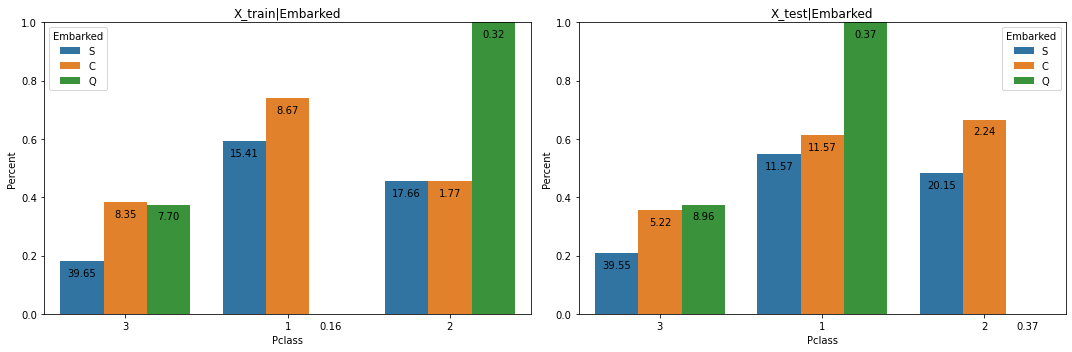

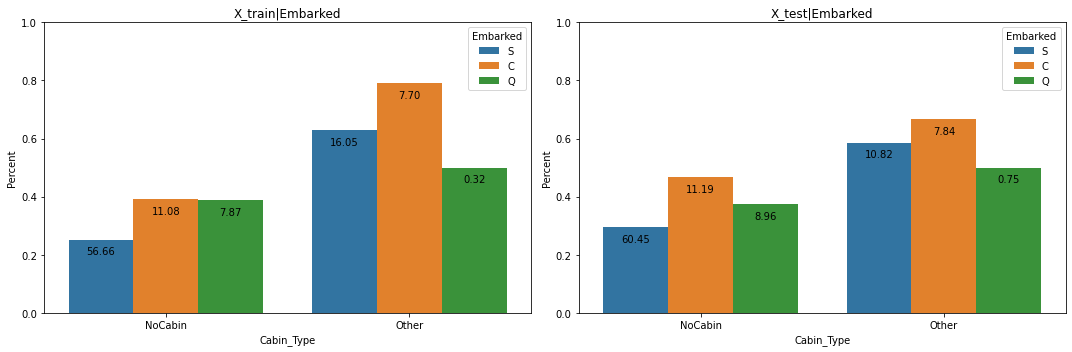

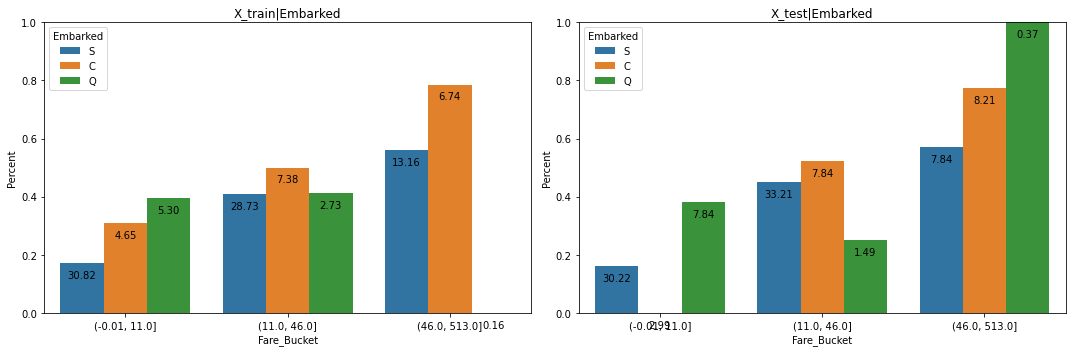

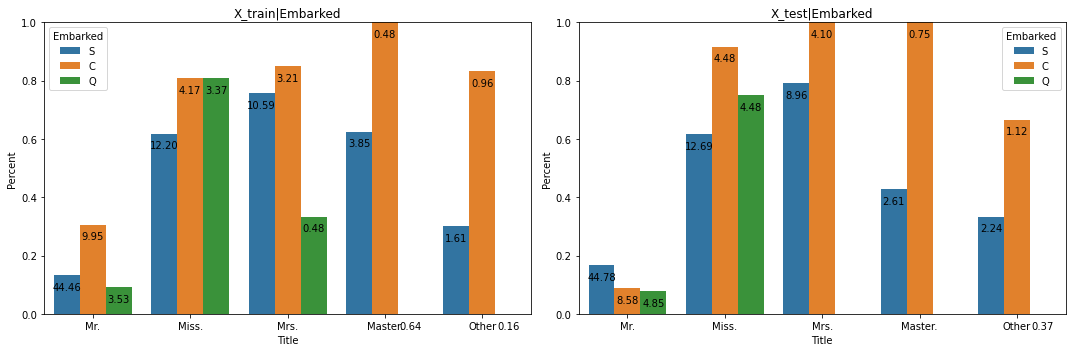

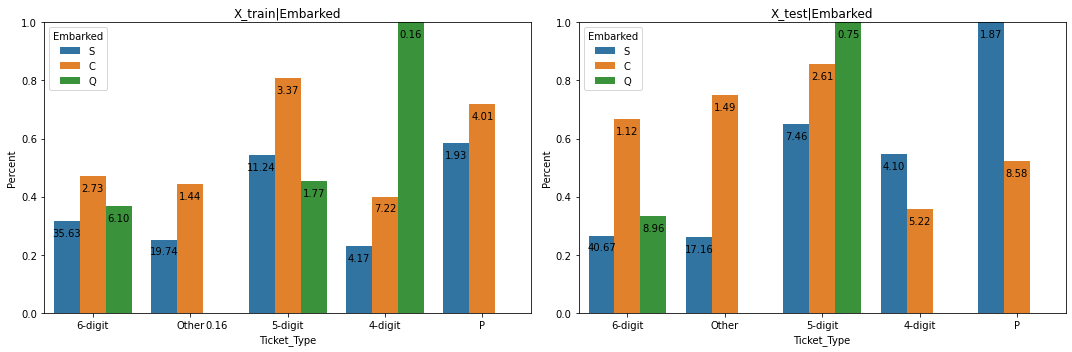

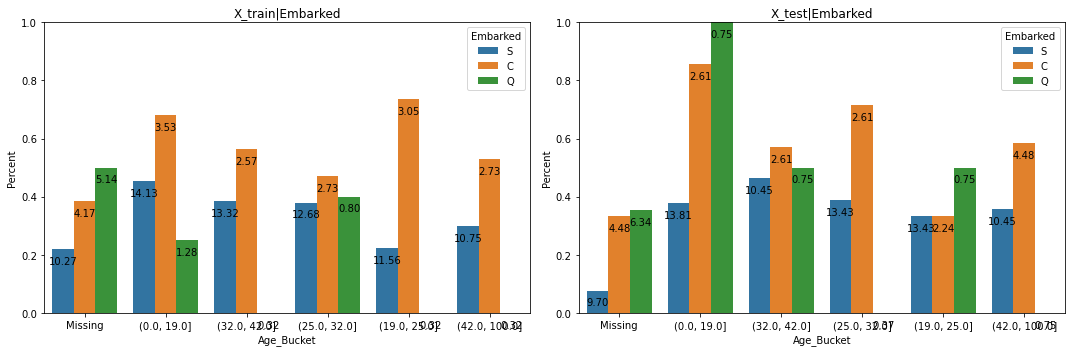

In [113]:
vars_to_analyse = ['Pclass','Cabin_Type','Fare_Bucket','Title','Ticket_Type','Age_Bucket']

for var in vars_to_analyse:
    two_categories_relation_with_target(X_train, X_test, 'Embarked', var)

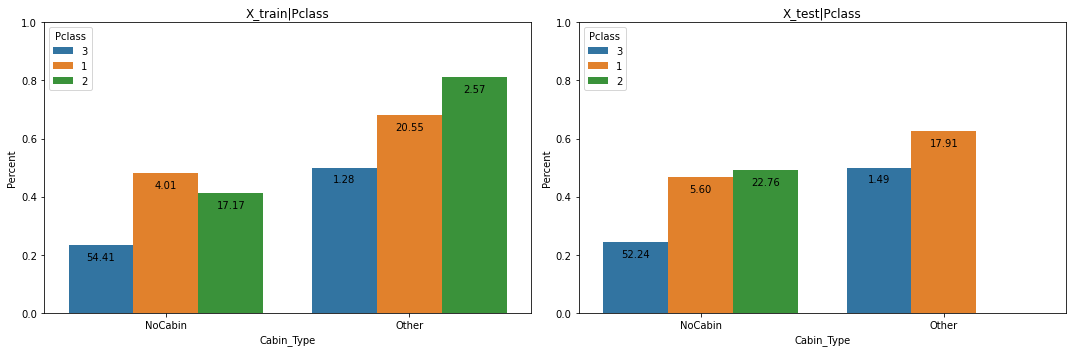

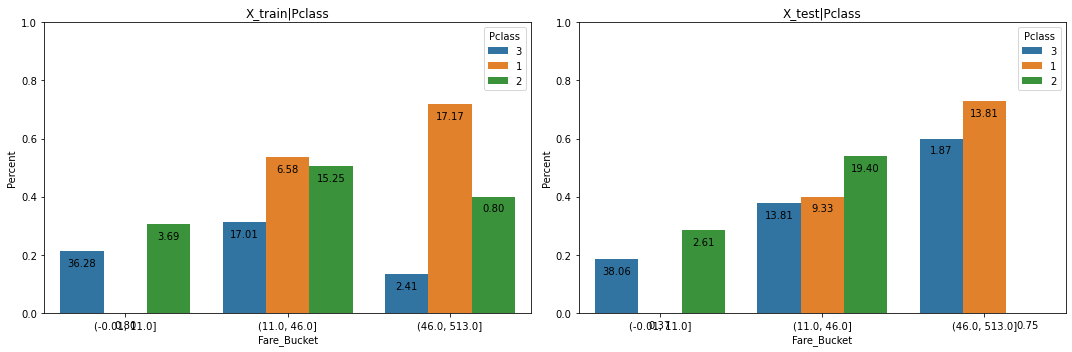

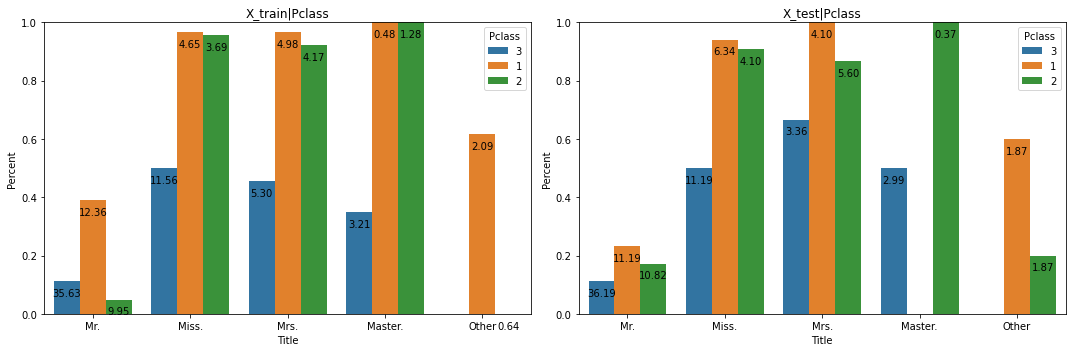

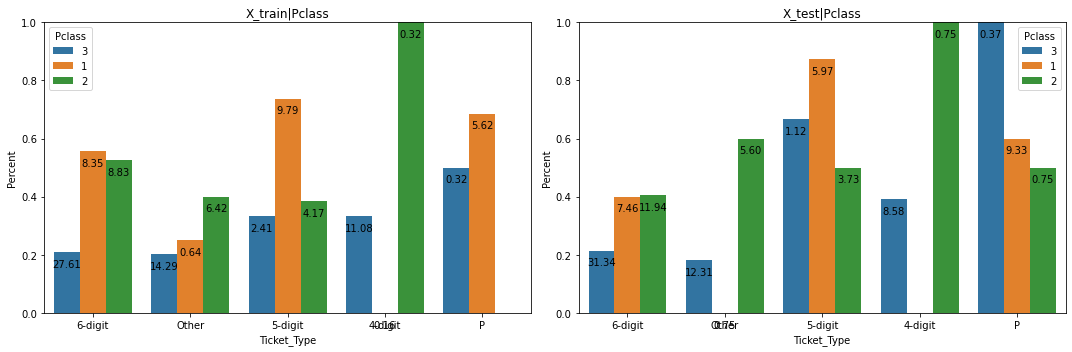

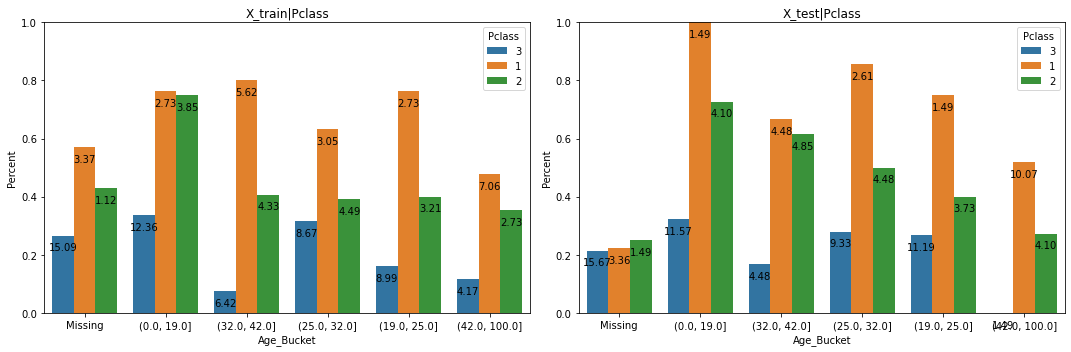

In [114]:
vars_to_analyse = ['Cabin_Type','Fare_Bucket','Title','Ticket_Type','Age_Bucket']

for var in vars_to_analyse:
    two_categories_relation_with_target(X_train, X_test, 'Pclass', var)

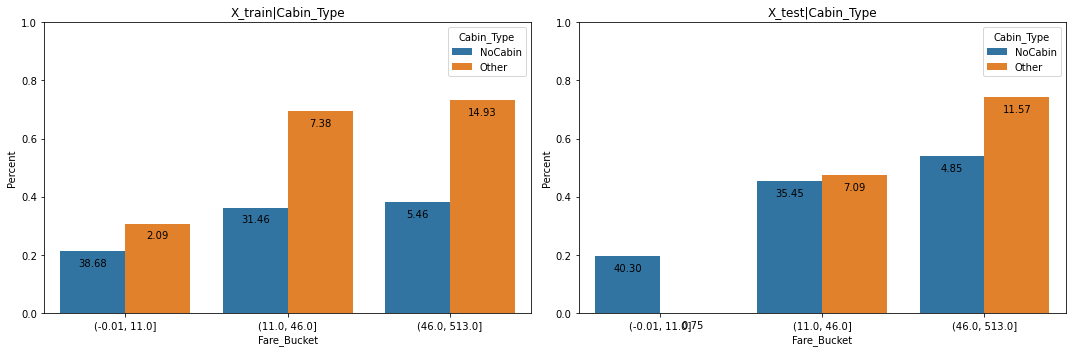

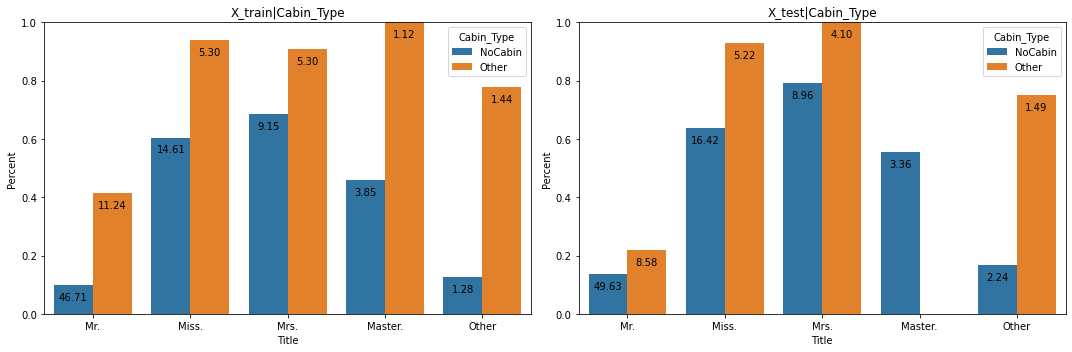

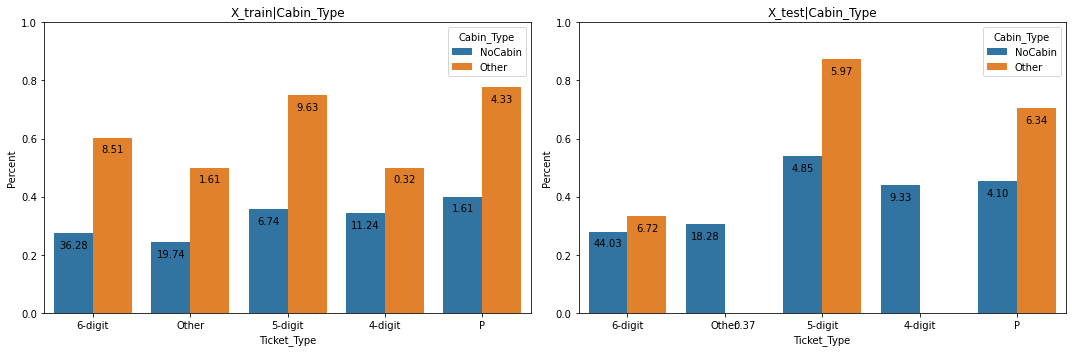

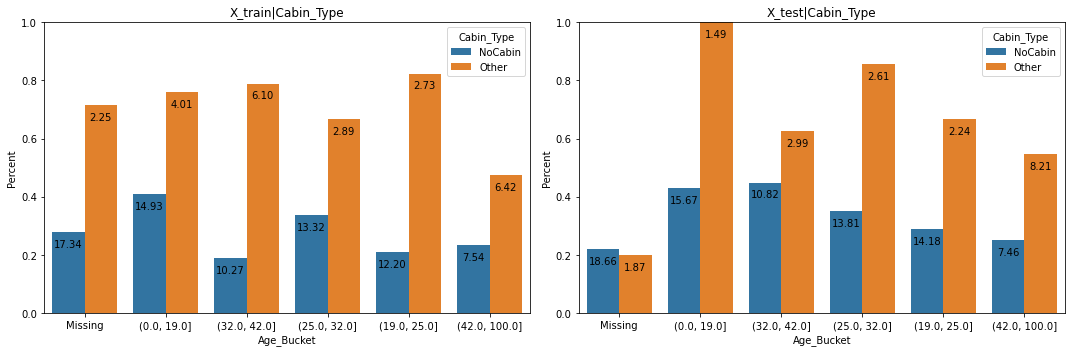

In [115]:
vars_to_analyse = ['Fare_Bucket','Title','Ticket_Type','Age_Bucket']

for var in vars_to_analyse:
    two_categories_relation_with_target(X_train, X_test, 'Cabin_Type', var)

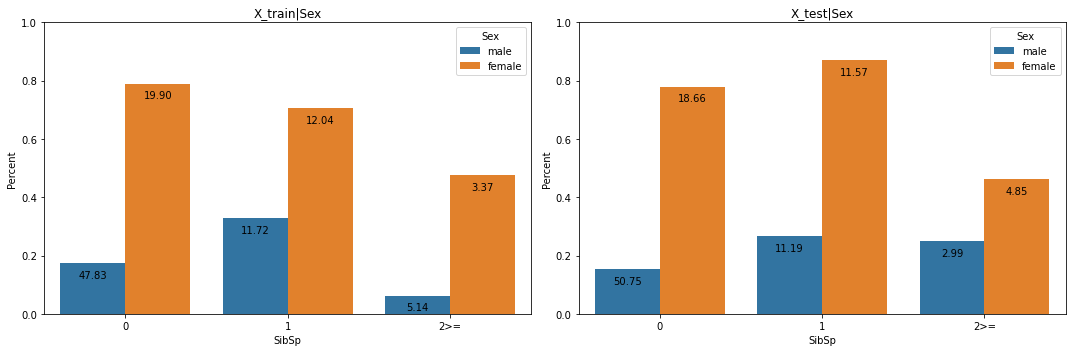

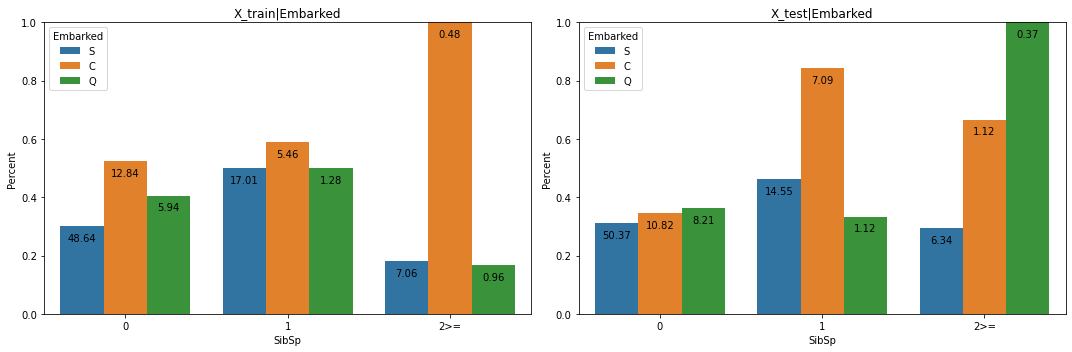

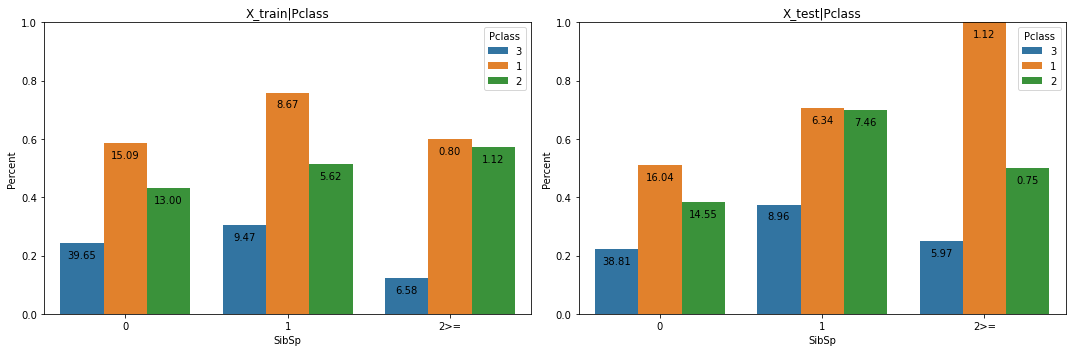

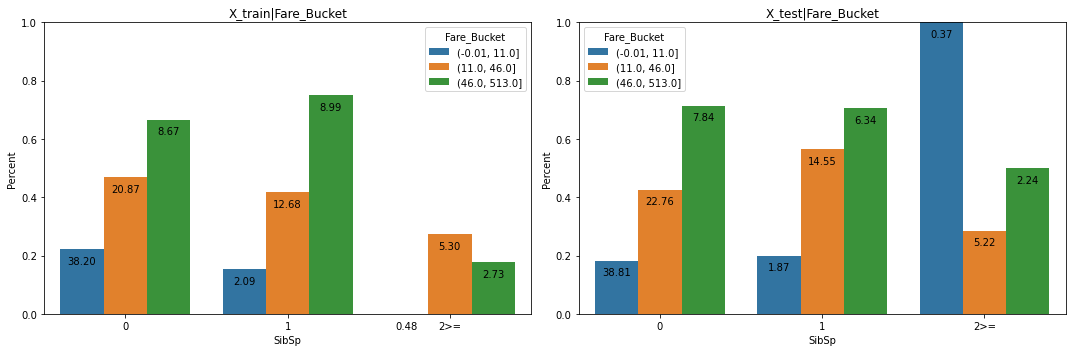

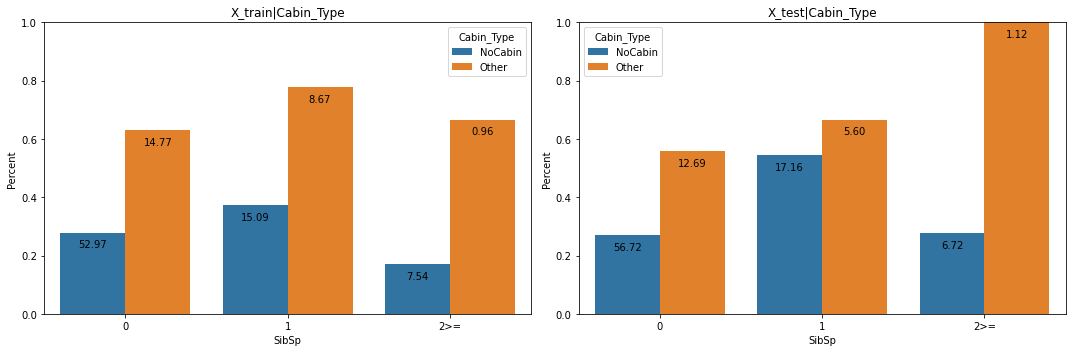

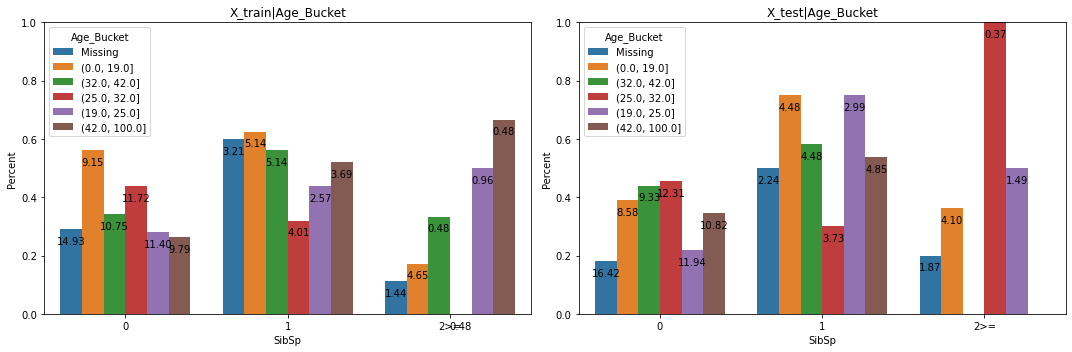

In [116]:
vars_to_analyse = ['Sex','Embarked','Pclass','Fare_Bucket','Cabin_Type','Age_Bucket']

for var in vars_to_analyse:
    two_categories_relation_with_target(X_train, X_test, var, 'SibSp')

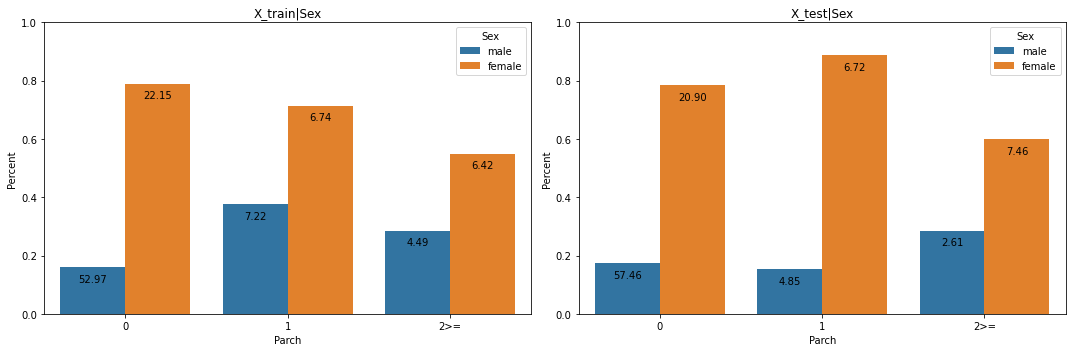

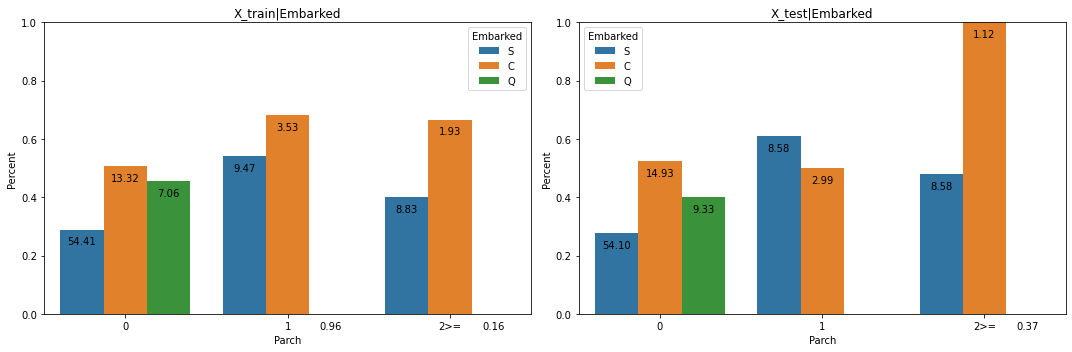

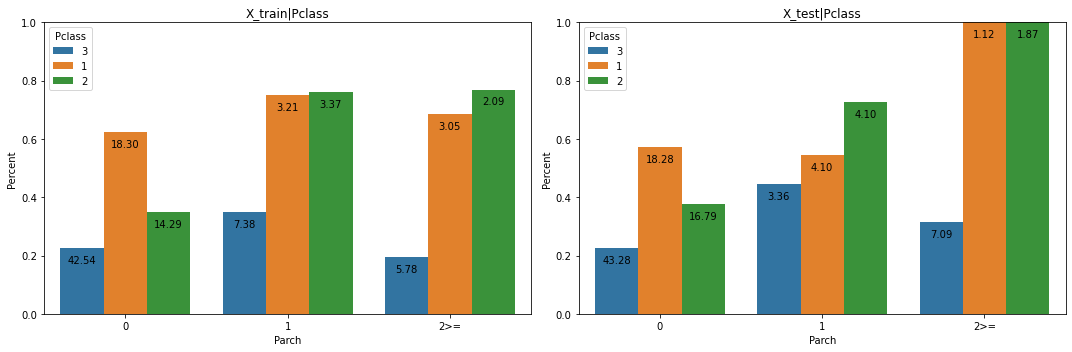

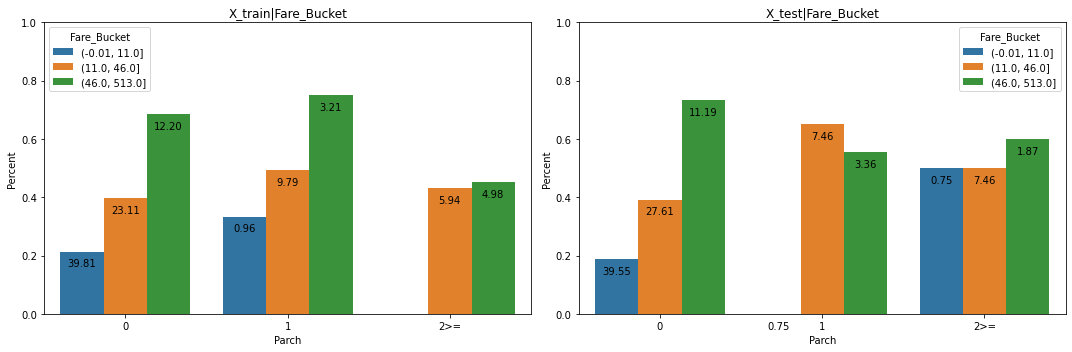

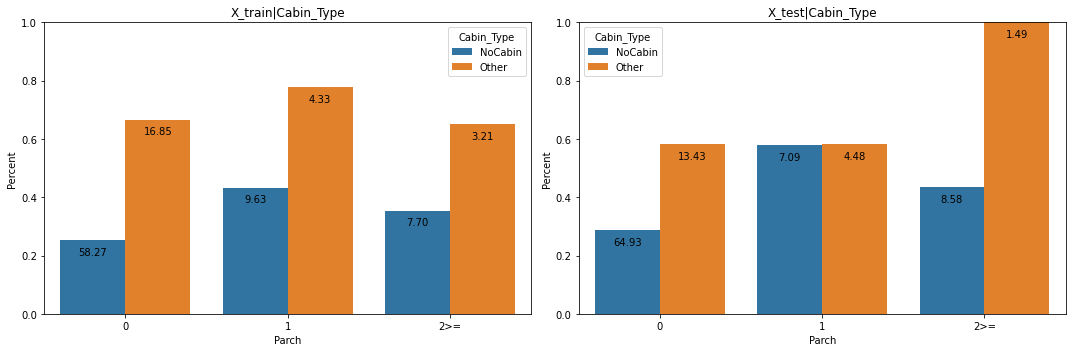

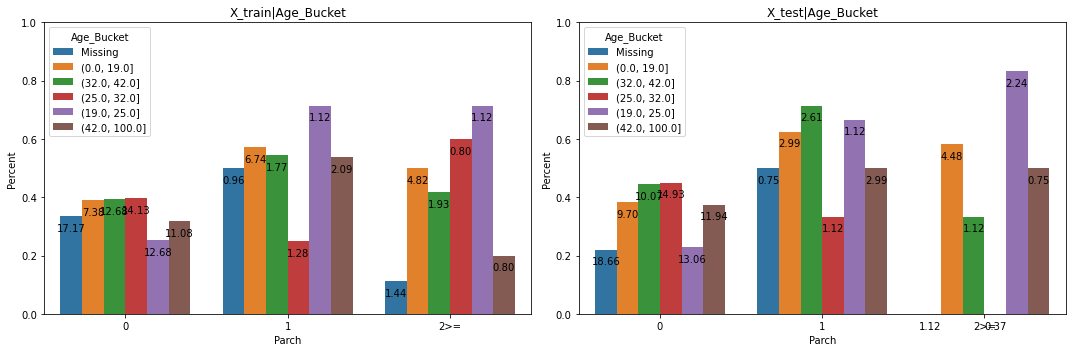

In [117]:
vars_to_analyse = ['Sex','Embarked','Pclass','Fare_Bucket','Cabin_Type','Age_Bucket']

for var in vars_to_analyse:
    two_categories_relation_with_target(X_train, X_test, var, 'Parch')

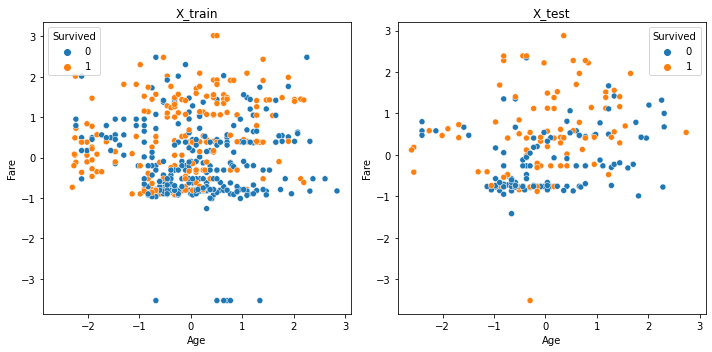

In [97]:
df = concatenate_datasets(X_train, X_test)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
for dataset, ax in zip(df['Dataset'].unique(), axes.flatten()):
    tmp = df[df['Dataset']==dataset]
    pt = PowerTransformer()
    tmp[['Age','Fare']] = pt.fit_transform(tmp[['Age','Fare']])
    sns.scatterplot(x='Age', y='Fare', hue='Survived', data=tmp, ax=ax)
    ax.set_xlabel('Age')
    ax.set_ylabel('Fare')
    ax.set_title(dataset)
plt.tight_layout()
plt.show()

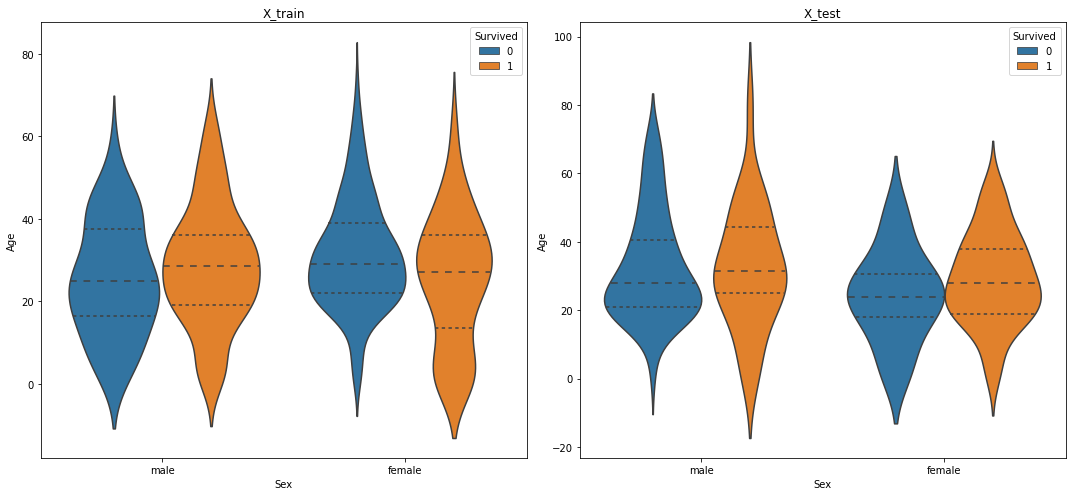

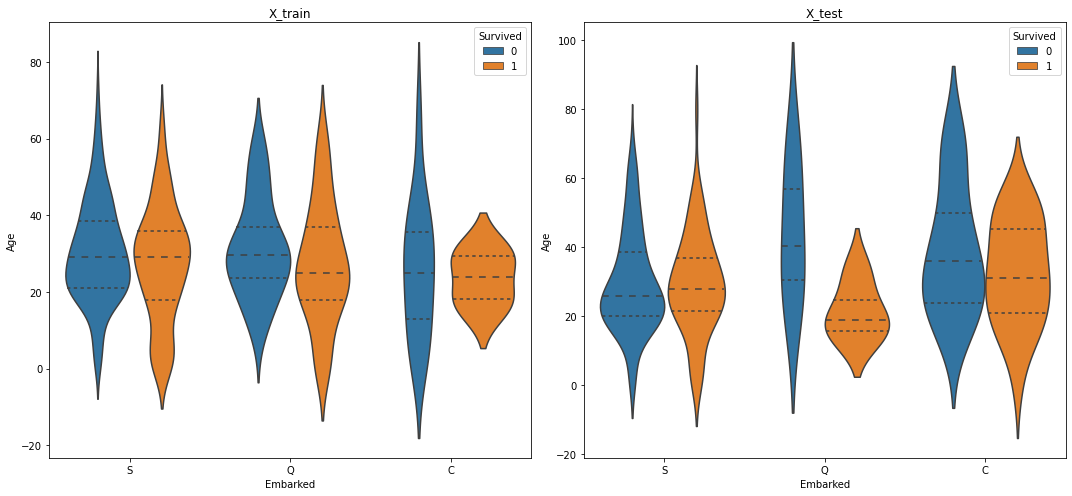

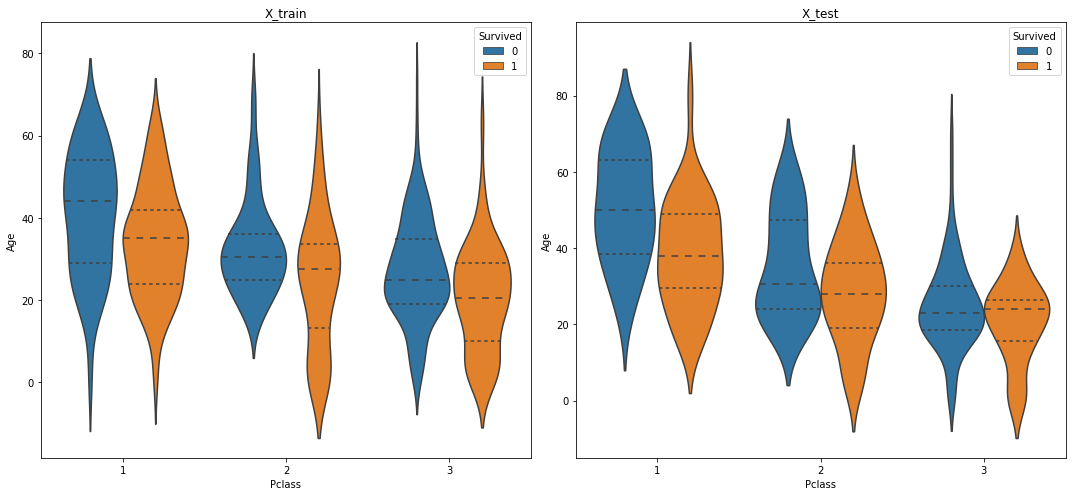

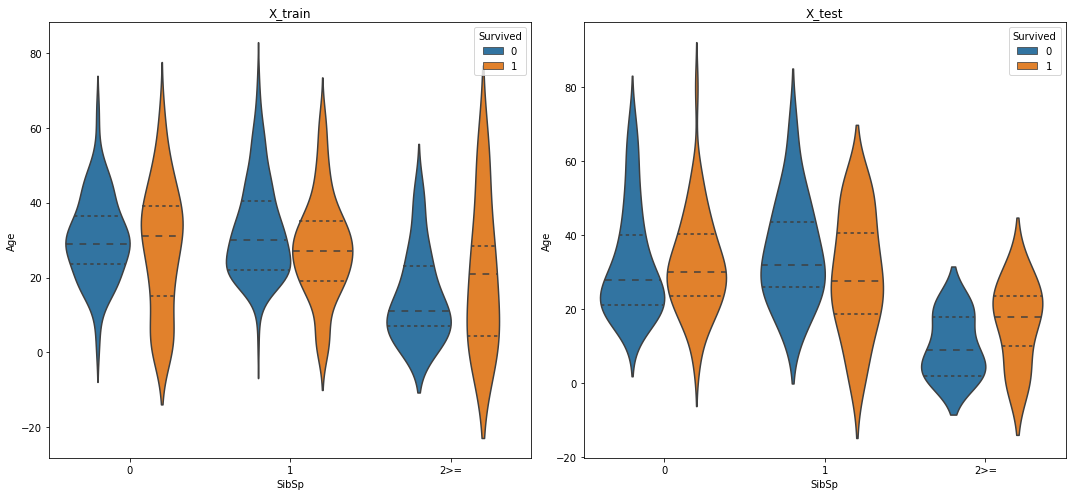

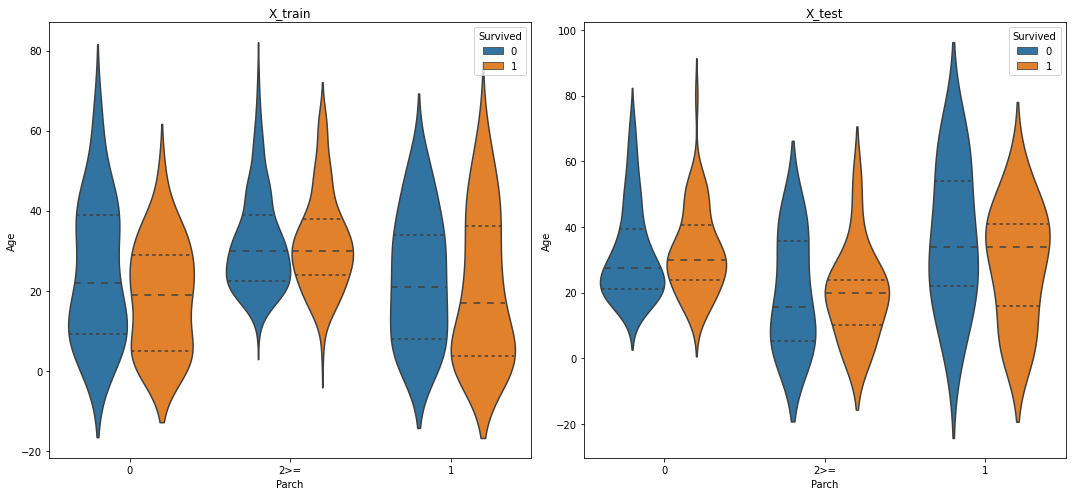

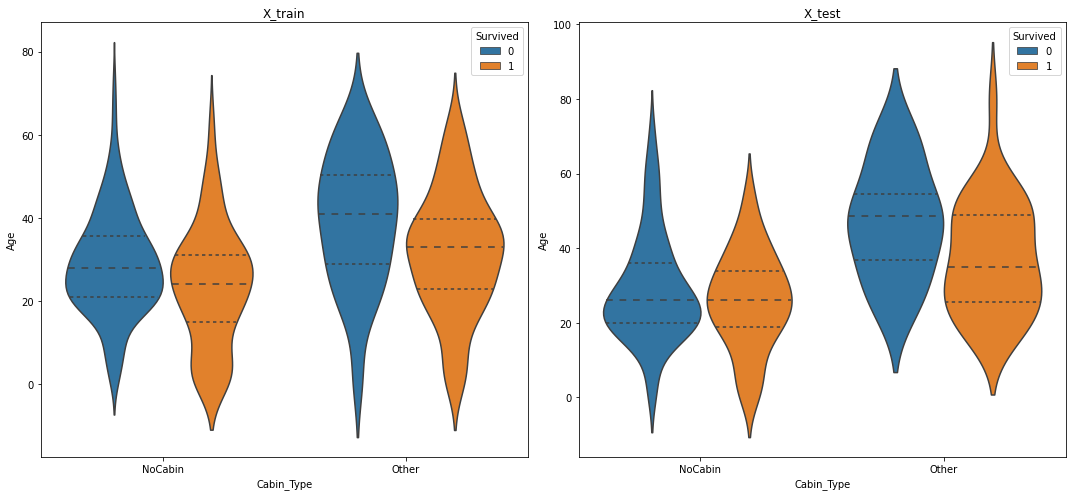

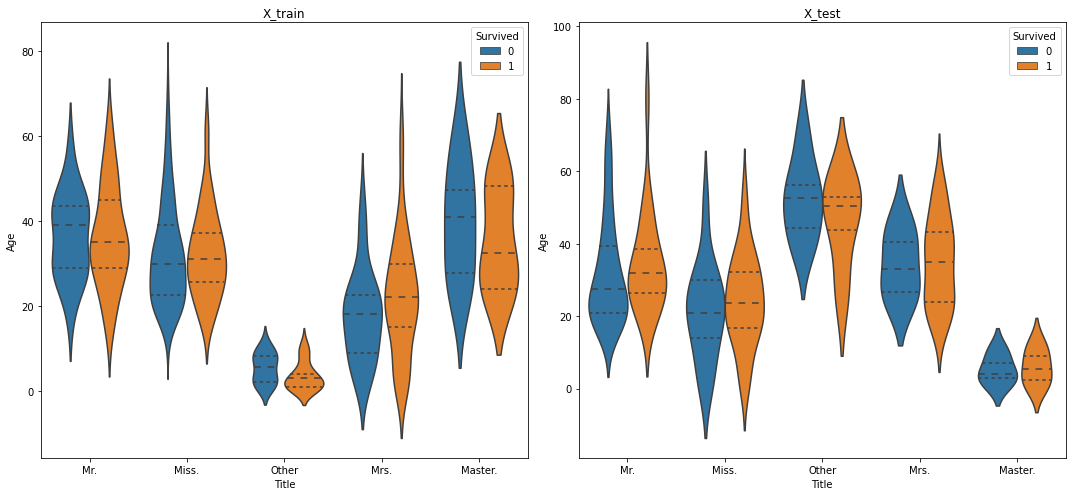

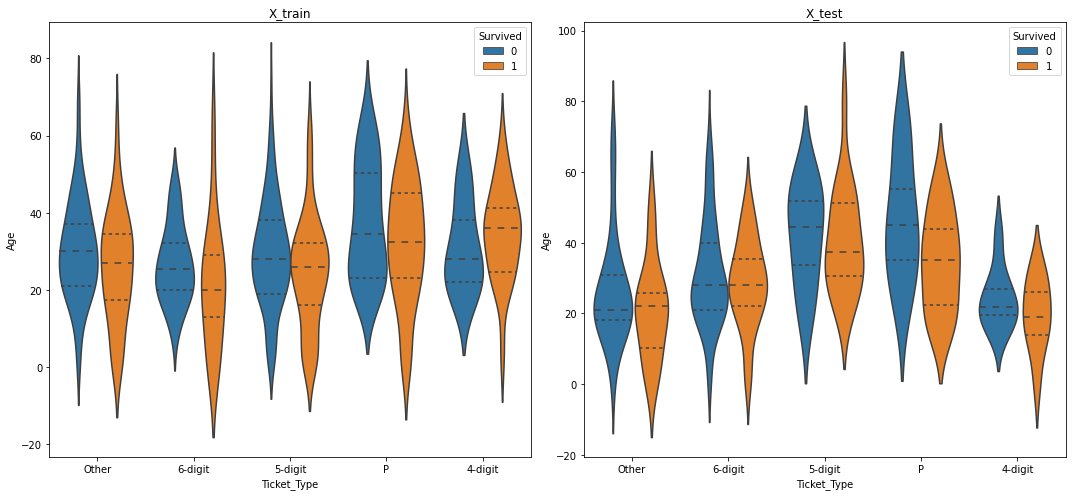

In [98]:
df = concatenate_datasets(X_train, X_test)

for var in ['Sex','Embarked','Pclass','SibSp','Parch','Cabin_Type','Title','Ticket_Type']:
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,7))
    for dataset, ax in zip(df['Dataset'].unique(), axes.flatten()):
        tmp = df[df['Dataset']==dataset]
        sns.violinplot(x=var, y='Age', hue='Survived', data=tmp, inner='quartile', ax=ax)
        ax.set_xlabel(var)
        ax.set_ylabel('Age')
        ax.set_title(dataset)
    plt.tight_layout()
    plt.show()

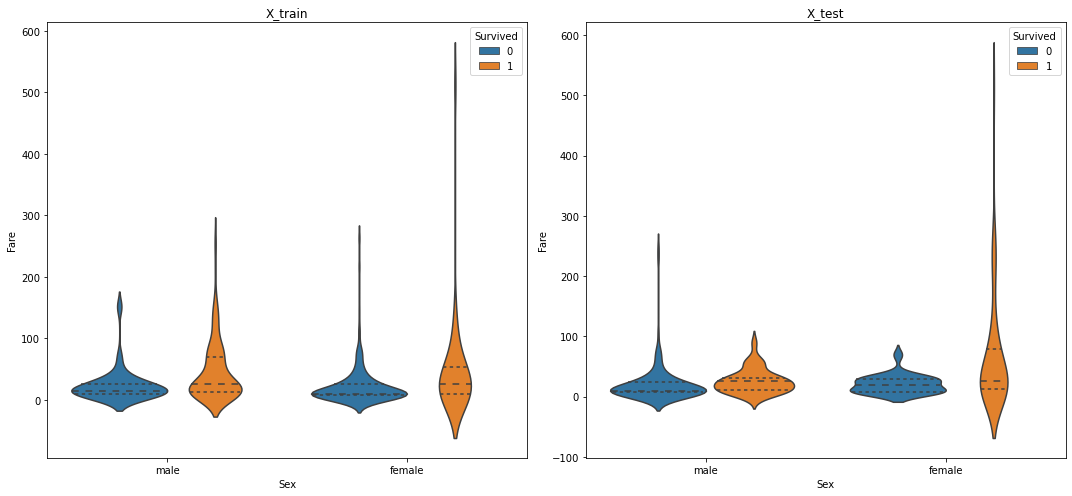

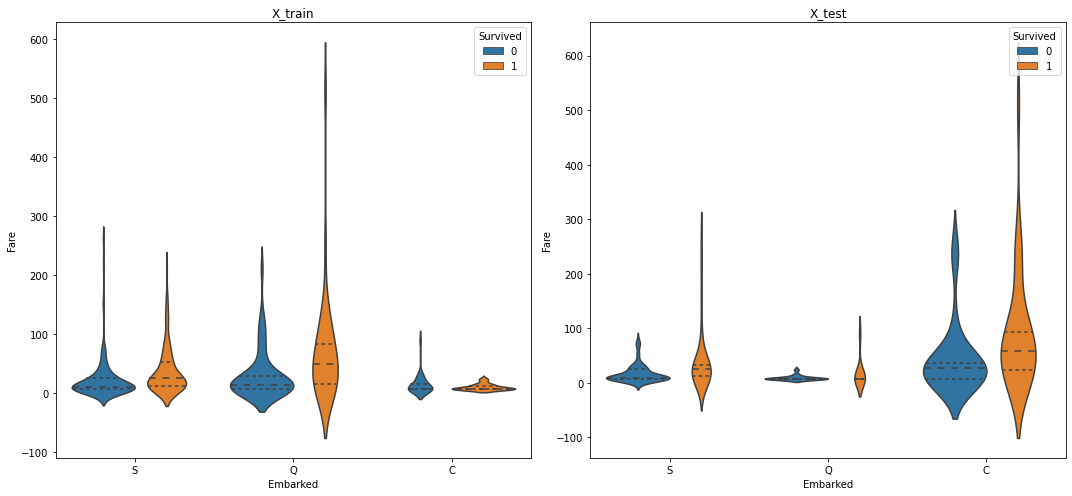

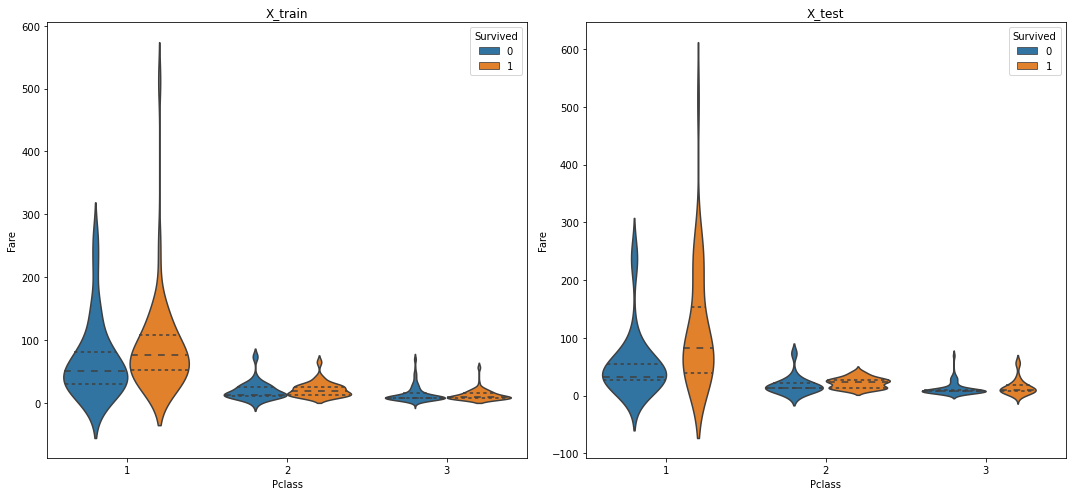

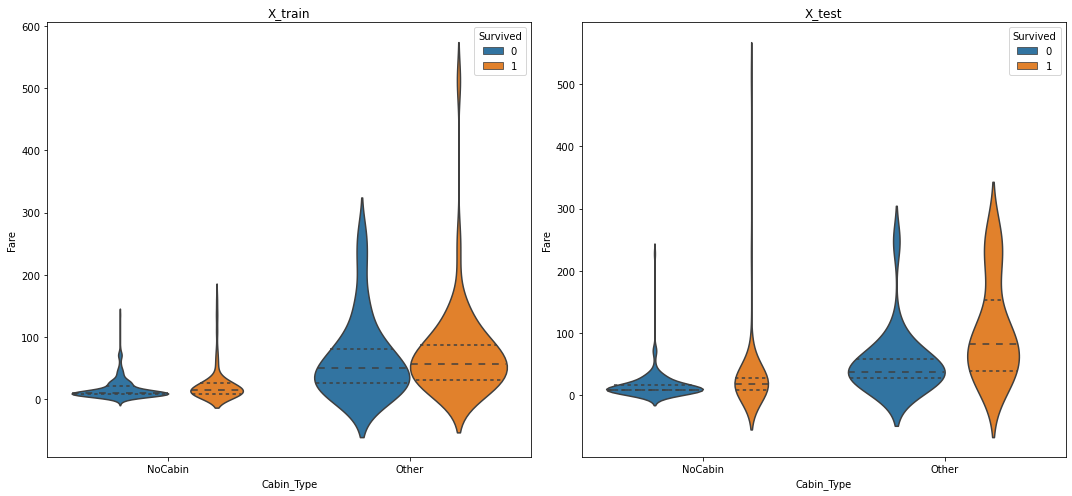

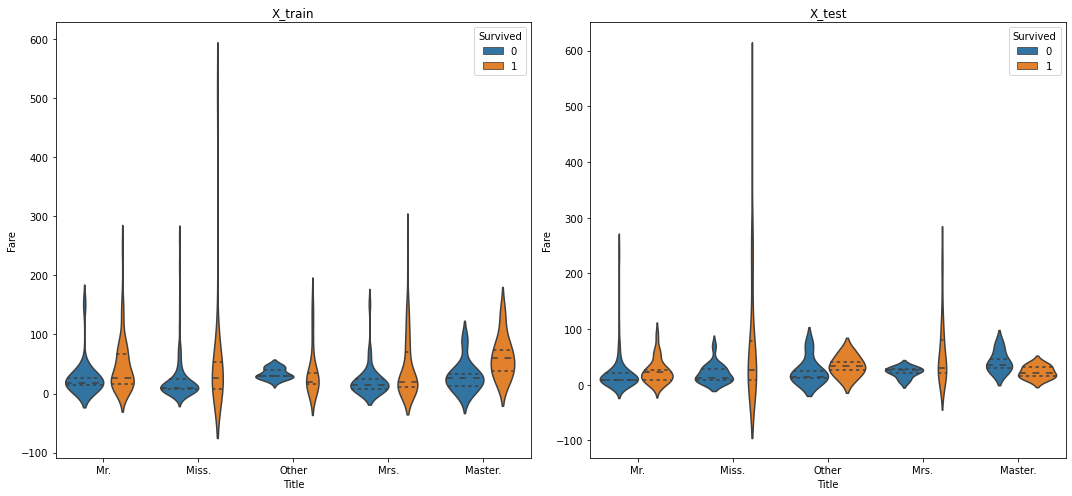

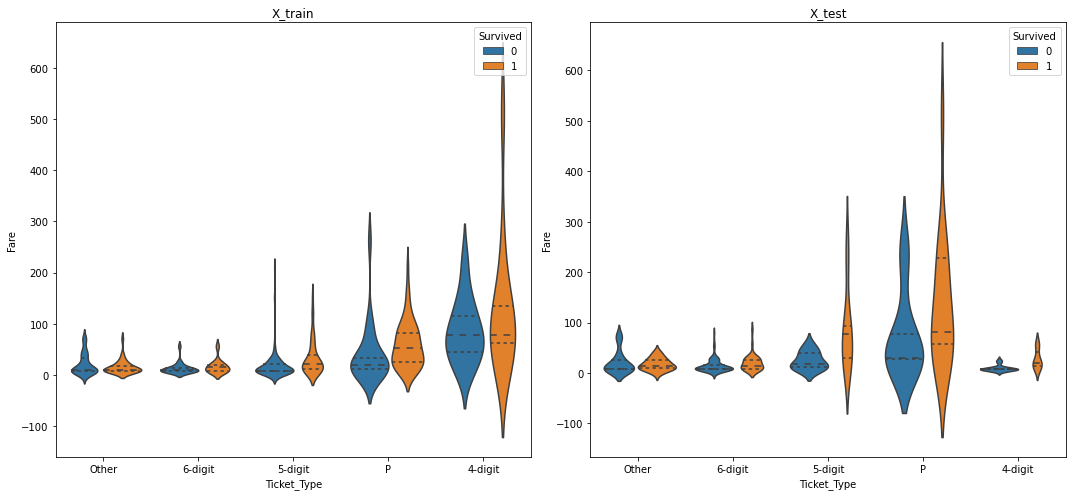

In [99]:
df = concatenate_datasets(X_train, X_test)

for var in ['Sex','Embarked','Pclass','Cabin_Type','Title','Ticket_Type']:
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,7))
    for dataset, ax in zip(df['Dataset'].unique(), axes.flatten()):
        tmp = df[df['Dataset']==dataset]
        sns.violinplot(x=var, y='Fare', hue='Survived', data=tmp, inner='quartile', ax=ax)
        ax.set_xlabel(var)
        ax.set_ylabel('Fare')
        ax.set_title(dataset)
    plt.tight_layout()
    plt.show()